# Project : Speed dating - Exporatory Data Analysis

## 1. First look at the data 

### 1.1. Overview

In [1]:
# Installing last version of plotly to avoid some bugs
!python -m pip install --upgrade plotly 

Description of the variables is available [here](./Speed%20Dating%20Data%20Key.pdf)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.renderers.default = "iframe_connected"

RANDOM_SEED = 0

df = pd.read_csv('Speed Dating Data.csv', encoding='ISO-8859-1')
print(df.shape)
df.head()

(8378, 195)


,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [3]:
pd.options.display.precision = 2
pd.options.display.max_columns = 200
pd.options.display.max_colwidth = 15
display(df)

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,1,11.0,0,0.14,0,27.0,2.0,35.0,20.0,20.0,20.0,0.0,5.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,2,12.0,0,0.54,0,22.0,2.0,60.0,0.0,0.0,40.0,0.0,0.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,3,13.0,1,0.16,1,22.0,4.0,19.0,18.0,19.0,18.0,14.0,12.0,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,4,14.0,1,0.61,0,23.0,2.0,30.0,5.0,15.0,40.0,5.0,5.0,1,7.0,8.0,9.0,8.0,9

### 1.2. What's in a row ?

Reading the data key document and observing the dataset's structure, a row seems to correspond to one date between 2 participants of opposite sex (the 'subject' and the 'partner'), **from the subject's point of view (for each person, a unique date is respresented by two rows : one with the person as the 'subject' and another with the same person as a 'partner')**

The subject is identified by : 
- **its unique id 'iid'**, (we assume that each subject has participated to only one wave)
- its id within wave 'idg', unique for each subject in wave _(contrarily to what is stated in the data key document)_ 
- its id within wave and gender 'id', unique for each subject in gender and wave _(contrarily to what is stated in the data key document)_

In a similar way, the partner is identified by : 
- **its unique id 'pid' (corresponding to 'iid')**
- its id within wave 'partner' (corresponding to 'id')

Let's take the example of wave 2 to visualize it : 

In [4]:
df_w2 = df[df['wave']==2]
df_w2

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
200,21,1.0,0,1,2,2,16,5,NaN,6,1,40.0,0,-0.23,1,25.0,4.0,25.0,20.0,25.0,20.0,10.0,0.0,0,3.0,10.0,10.0,6.0,4.0,7.0,4.0,1.0,2.0,21.0,Operations ...,5.0,NaN,NaN,NaN,4.0,8.0,10.0,New Jersey,"7,661",NaN,6.0,7.0,4.0,Undecided,10.0,10.0,8.0,10.0,5.0,5.0,5.0,2.0,1.0,3.0,7.0,10.0,4.0,7.0,4.0,8.0,5.0,2.0,5.0,0.0,12.0,18.0,20.0,16.0,16.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,15.0,10.0,15.0,5.0,20.0,5.0,9.0,7.0,9.0,10.0,NaN,NaN,NaN,NaN,NaN,0,6.0,8.0,7.0,9.0,5.0,7.0,9.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,15.0,20.0,15.0,10.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,9.0,9.0,7.0,10.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,15.0,20.0,20.0,20.0,10.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,9.0,9.0,7.0,9.0,NaN,NaN,NaN,NaN,NaN
201,21,1.0,0,1,2,2,16,5,NaN,7,2,41.0,0,-0.30,1,30.0,4.0,30.0,20.0,10.0,30.0,0.0,10.0,0,5.0,5.0,5.0,5.0,5.0,NaN,5.0,NaN,2.0,21.0,Operations ...,5.0,NaN,NaN,NaN,4.0,8.0,10.0,New Jersey,"7,661",NaN,6.0,7.0,4.0,Undecided,10.0,10.0,8.0,10.0,5.0,5.0,5.0,2.0,1.0,3.0,7.0,10.0,4.0,7.0,4.0,8.0,5.0,2.0,5.0,0.0,12.0,18.0,20.0,16.0,16.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,15.0,10.0,15.0,5.0,20.0,5.0,9.0,7.0,9.0,10.0,NaN,NaN,NaN,NaN,NaN,0,5.0,8.0,7.0,5.0,9.0,5.0,7.0,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,15.0,20.0,15.0,10.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,9.0,9.0,7.0,10.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,15.0,20.0,20.0,20.0,10.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,9.0,9.0,7.0,9.0,NaN,NaN,NaN,NaN,NaN
202,21,1.0,0,1,2,2,16,5,NaN,8,3,42.0,0,0.46,1,23.0,4.0,20.0,25.0,20.0,15.0,10.0,10.0,0,3.0,10.0,9.0,5.0,9.0,2.0,6.0,7.0,2.0,21.0,Operations ...,5.0,NaN,NaN,NaN,4.0,8.0,10.0,New Jersey,"7,661",NaN,6.0,7.0,4.0,Undecided,10.0,10.0,8.0,10.0,5.0,5.0,5.0,2.0,1.0,3.0,7.0,10.0,4.0,7.0,4.0,8.0,5.0,2.0,5.0,0.0,12.0,18.0,20.0,16.0,16.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,15.0,10.0,15.0,5.0,20.0,5.0,9.0,7.0,9.0,10.0,NaN,NaN,NaN,NaN,NaN,1,8.0,9.0,8.0,8.0,7.0,6.0,9.0,3.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,15.0,20.0,15.0,10.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,9.0,9.0,7.0,10.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,15.0,20.0,20.0,20.0,10.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,9.0,9.0,7.0,9.0,NaN,NaN,NaN,NaN,NaN
203,21,1.0,0,1,2,2,16,5,NaN,11,4,43.0,0,0.43,0,24.0,2.0,25.0,35.0,

In [5]:
female_participants_iid_w2 = list(np.sort(df_w2[df_w2['gender']==0]['iid'].unique()))
male_participants_iid_w2 = list(np.sort(df_w2[df_w2['gender']==1]['iid'].unique()))

female_participants_nb_w2 = len(female_participants_iid_w2)
male_participants_nb_w2 = len(male_participants_iid_w2)

female_participants_idg_w2 = list(np.sort(df_w2[df_w2['gender']==0]['idg'].unique()))
male_participants_idg_w2 = list(np.sort(df_w2[df_w2['gender']==1]['idg'].unique()))

female_participants_id_w2 = list(np.sort(df_w2[df_w2['gender']==0]['id'].astype(int).unique()))
male_participants_id_w2 = list(np.sort(df_w2[df_w2['gender']==1]['id'].astype(int).unique()))

female_example_iid = female_participants_iid_w2[0]
male_example_iid = male_participants_iid_w2[0]

def who_they_met_in_wave2(subject_iid):
    return df_w2[df_w2['iid']==subject_iid]['pid'].astype(int).sort_values().tolist()

print("--------------------------------------------------------- Wave 2 ----------------------------------------------------------------------------------")
print(f"Number of participants : {female_participants_nb_w2} women and {male_participants_nb_w2} men ")
print(f"Female participants iids : {female_participants_iid_w2}")
print(f"Male participants iids : {male_participants_iid_w2}")
print()
print(f"Female participants idgs : {female_participants_idg_w2}")
print(f"Male participants idgs : {male_participants_idg_w2}")
print()
print(f"Female participants ids : {female_participants_id_w2}")
print(f"Male participants ids : {male_participants_id_w2}")
print()
print("For example :",
      f"    - participant with iid nb. {female_example_iid} (female) met with {len(who_they_met_in_wave2(female_example_iid))} men with following iids : {who_they_met_in_wave2(female_example_iid)}",
      f"    - participant with iid nb. {male_example_iid} (male) met with {len(who_they_met_in_wave2(male_example_iid))} women with following iids : {who_they_met_in_wave2(male_example_iid)}",
      sep = "\n")

--------------------------------------------------------- Wave 2 ----------------------------------------------------------------------------------
Number of participants : 19 women and 16 men 
Female participants iids : [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Male participants iids : [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]

Female participants idgs : [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 34, 35]
Male participants idgs : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]

Female participants ids : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20]
Male participants ids : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

For example :
    - participant with iid nb. 21 (female) met with 16 men with following iids : [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
    - participant with iid nb. 40 (male) met with 19 women with following iids : [21, 22, 

=> We see that generally, each woman meets with all men in her wave and vice-versa.  

### 1.3. Identifiers (subjects and partners)

In [6]:
print(f"Number of subjects : {len(df['iid'][df['iid'].notna()].unique())}")
print(f"Number of partners : {len(df['pid'][df['pid'].notna()].unique())}")
print(f"Are the iids and pids the same ? => {np.array_equal(np.sort(df['iid'][df['iid'].notna()].unique()), np.sort(df['pid'][df['pid'].notna()].unique()))}")

Number of subjects : 551
Number of partners : 551
Are the iids and pids the same ? => True


In [7]:
print("Missing values for 'iid' : ", df['iid'].isnull().sum())
print("Missing values for 'pid' : ", df['pid'].isnull().sum())

Missing values for 'iid' :  0
Missing values for 'pid' :  10


In [8]:
df[df['pid'].isna()]

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
1755,122,1.0,1,2,1,5,10,4,NaN,6,7,NaN,0,-0.12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,Law,1.0,NaN,NaN,NaN,6.0,1.0,1.0,Long Island,"11,793","57,887.00",1.0,3.0,1.0,Lawyer,1.0,7.0,9.0,7.0,9.0,7.0,6.0,5.0,6.0,6.0,6.0,8.0,7.0,8.0,8.0,8.0,5.0,4.0,6.0,10.0,40.0,15.0,10.0,20.0,5.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,50.0,10.0,10.0,10.0,10.0,10.0,7.0,10.0,8.0,8.0,8.0,NaN,NaN,NaN,NaN,NaN,0,6.0,10.0,8.0,8.0,8.0,8.0,8.0,4.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,50.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,10.0,8.0,8.0,8.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,NaN,NaN,50.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,10.0,8.0,8.0,8.0,NaN,NaN,NaN,NaN,NaN
1765,123,2.0,1,4,1,5,10,4,NaN,10,7,NaN,0,-0.29,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,Biomedical ...,5.0,NaN,NaN,NaN,4.0,3.0,5.0,Louisiana,"70,605","30,768.00",2.0,5.0,1.0,Cardiologist,4.0,9.0,9.0,8.0,8.0,3.0,2.0,5.0,5.0,6.0,2.0,7.0,2.0,7.0,7.0,7.0,7.0,5.0,5.0,1.0,50.0,10.0,20.0,5.0,5.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,50.0,10.0,5.0,5.0,10.0,8.0,7.0,7.0,7.0,8.0,NaN,NaN,NaN,NaN,NaN,0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,1.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,80.0,4.0,5.0,3.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,7.0,7.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1775,124,3.0,1,6,1,5,10,4,NaN,3,7,NaN,0,-0.05,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,Economics a...,8.0,NaN,NaN,NaN,4.0,1.0,1.0,Maryland,"20,815","66,699.00",2.0,4.0,1.0,Law or finance,1.0,5.0,5.0,8.0,10.0,8.0,8.0,6.0,5.0,8.0,8.0,6.0,9.0,9.0,9.0,8.0,8.0,7.0,6.0,10.0,40.0,10.0,10.0,10.0,10.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,30.0,10.0,10.0,20.0,10.0,8.0,8.0,10.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,1,6.0,7.0,7.0,6.0,7.0,7.0,7.0,7.0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,50.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,7.0,10.0,8.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1785,125,4.0,1,8,1,5,10,4,NaN,8,7,NaN,0,0.15,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN

As we have no missing unique identifiers for the subject id, and only one case for the partner id, we can drop other identifier columns ('id','idg', 'partner') as they will not provide us useful information, and also drop the lines where 'pid' is nan.

In [9]:
df = df.drop(['id','idg','partner'], axis = 1)[~df['pid'].isna()]
print(df.shape)
df

(8368, 192)


,iid,gender,condtn,wave,round,position,positin1,order,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,0,1,1,10,7,NaN,4,11.0,0,0.14,0,27.0,2.0,35.0,20.0,20.0,20.0,0.0,5.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,0,1,1,10,7,NaN,3,12.0,0,0.54,0,22.0,2.0,60.0,0.0,0.0,40.0,0.0,0.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,0,1,1,10,7,NaN,10,13.0,1,0.16,1,22.0,4.0,19.0,18.0,19.0,18.0,14.0,12.0,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,0,1,1,10,7,NaN,5,14.0,1,0.61,0,23.0,2.0,30.0,5.0,15.0,40.0,5.0,5.0,1,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0

Let's take a look at the sample of data for one random subject : 

In [10]:
rng = np.random.default_rng(RANDOM_SEED)
display(df[df['iid']==rng.choice(df['iid'].unique())].sort_values('order'))

,iid,gender,condtn,wave,round,position,positin1,order,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
6943,470,0,2,19,15,13,14.0,1,488.0,1,0.56,1,29.0,4.0,15.0,20.0,20.0,20.0,5.0,20.0,1,8.0,8.0,8.0,8.0,8.0,8.0,8.0,5.0,2.0,29.0,medicine,4.0,harvard,"1,400.00","26,019.00",4.0,1.0,1.0,south carolina,"29,571","18,619.00",1.0,4.0,2.0,medicine,4.0,1.0,1.0,1.0,10.0,10.0,10.0,2.0,1.0,3.0,10.0,5.0,10.0,10.0,6.0,6.0,10.0,1.0,4.0,NaN,10.0,20.0,25.0,25.0,10.0,10.0,40.0,10.0,20.0,10.0,10.0,10.0,60.0,10.0,10.0,10.0,5.0,5.0,4.0,9.0,5.0,8.0,6.0,4.0,9.0,8.0,5.0,6.0,1,5.0,5.0,5.0,8.0,5.0,5.0,7.0,7.0,0.0,4.0,6.0,6.0,9.0,8.0,2.0,2.0,5.0,8.0,8.0,5.0,5.0,2.0,3.0,2.0,35.0,10.0,25.0,10.0,5.0,15.0,20.0,15.0,30.0,20.0,10.0,5.0,50.0,10.0,10.0,10.0,10.0,10.0,60.0,10.0,5.0,15.0,5.0,5.0,4.0,7.0,7.0,7.0,9.0,3.0,9.0,9.0,2.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6944,470,0,2,19,15,13,14.0,2,489.0,1,0.26,0,28.0,2.0,20.0,10.0,20.0,20.0,20.0,0.0,1,7.0,7.0,9.0,9.0,8.0,7.0,10.0,8.0,2.0,29.0,medicine,4.0,harvard,"1,400.00","26,019.00",4.0,1.0,1.0,south carolina,"29,571","18,619.00",1.0,4.0,2.0,medicine,4.0,1.0,1.0,1.0,10.0,10.0,10.0,2.0,1.0,3.0,10.0,5.0,10.0,10.0,6.0,6.0,10.0,1.0,4.0,NaN,10.0,20.0,25.0,25.0,10.0,10.0,40.0,10.0,20.0,10.0,10.0,10.0,60.0,10.0,10.0,10.0,5.0,5.0,4.0,9.0,5.0,8.0,6.0,4.0,9.0,8.0,5.0,6.0,1,7.0,7.0,5.0,7.0,5.0,7.0,8.0,5.0,0.0,4.0,6.0,6.0,9.0,8.0,2.0,2.0,5.0,8.0,8.0,5.0,5.0,2.0,3.0,2.0,35.0,10.0,25.0,10.0,5.0,15.0,20.0,15.0,30.0,20.0,10.0,5.0,50.0,10.0,10.0,10.0,10.0,10.0,60.0,10.0,5.0,15.0,5.0,5.0,4.0,7.0,7.0,7.0,9.0,3.0,9.0,9.0,2.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6946,470,0,2,19,15,13,14.0,3,491.0,1,0.23,0,29.0,3.0,30.0,10.0,25.0,20.0,8.0,7.0,1,8.0,7.0,7.0,8.0,8.0,6.0,7.0,6.0,2.0,29.0,medicine,4.0,harvard,"1,400.00","26,019.00",4.0,1.0,1.0,south carolina,"29,571","18,619.00",1.0,4.0,2.0,medicine,4.0,1.0,1.0,1.0,10.0,10.0,10.0,2.0,1.0,3.0,10.0,5.0,10.0,10.0,6.0,6.0,10.0,1.0,4.0,NaN,10.0,20.0,25.0,25.0,10.0,10.0,40.0,10.0,20.0,10.0,10.0,10.0,60.0,10.0,10.0,10.0,5.0,5.0,4.0,9.0,5.0,8.0,6.0,4.0,9.0,8.0,5.0,6.0,1,7.0,6.0,8.0,5.0,5.0,4.0,7.0,5.0,0.0,4.0,6.0,6.0,9.0,8.0,2.0,2.0,5.0,8.0,8.0,5.0,5.0,2.0,3.0,2.0,35.0,10.0,25.0,10.0,5.0,15.0,20.0,15.0,30.0,20.0,10.0,5.0,50.0,10.0,10.0,10.0,10.0,10.0,60.0,10.0,5.0,15.0,5.0,5.0,4.0,7.0,7.0,7.0,9.0,3.0,9.0,9.0,2.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

### 1.4. Getting data grouped by subject

Here the aggregation function we will use is mean, as :
- it will give us directly ratios for binary data (for example : 'samerace', matches'...)
- it will keep the value for datas that have a unique value which is subject-specific (for example 'gender', 'goal', 'race'...), even for non-numerical (if we set 'numeric_only' argument to None)

In [11]:
df.dtypes.value_counts()

float64    173
int64       11
object       8
dtype: int64

In [12]:
obj_col_list = [col for col in df.columns if df.dtypes[col]==object]
print(f"Found {len(obj_col_list)} non-numerical columns : {obj_col_list}")
num_col_list = [col for col in df.columns if col not in obj_col_list]
print(f"Found {len(num_col_list)} numerical columns : {num_col_list}")

Found 8 non-numerical columns : ['field', 'undergra', 'mn_sat', 'tuition', 'from', 'zipcode', 'income', 'career']
Found 184 numerical columns : ['iid', 'gender', 'condtn', 'wave', 'round', 'position', 'positin1', 'order', 'pid', 'match', 'int_corr', 'samerace', 'age_o', 'race_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o', 'age', 'field_cd', 'race', 'imprace', 'imprelig', 'goal', 'date', 'go_out', 'career_c', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'exphappy', 'expnum', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1', 'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 'attr5_1', 'sinc5_

Checking that non-numerical data is subject-specific before applying the aggregation : 

In [13]:
for col in obj_col_list:
    is_subject_specific = True
    for iid in df['iid'].unique():
        if len(df[df['iid']==iid][col].unique())>1:
            is_subject_specific = False
    if is_subject_specific == True:
        print(f"OK : Column '{col}' is subject-specific")
    else:
        print(f"WARNING : Column '{col}' is NOT subject-specific")

OK : Column 'field' is subject-specific
OK : Column 'undergra' is subject-specific
OK : Column 'mn_sat' is subject-specific
OK : Column 'tuition' is subject-specific
OK : Column 'from' is subject-specific
OK : Column 'zipcode' is subject-specific
OK : Column 'income' is subject-specific
OK : Column 'career' is subject-specific


In [14]:
df_by_iid = df.groupby('iid').agg({k:('mean' if k in num_col_list else 'first') for k in df.columns})
df_by_iid

,iid,gender,condtn,wave,round,position,positin1,order,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
iid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,1.0,1.0,10.0,7.0,NaN,5.5,15.5,0.40,2.67e-01,0.10,25.2,2.30,44.23,7.91,16.51,16.91,4.51,9.92,0.50,6.70,7.40,8.00,7.20,8.00,7.10,6.85,5.70,1.90,21.0,Law,1.0,None,None,None,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,0.80,5.70,7.30,7.30,6.80,6.30,6.50,6.50,5.89,1.78,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,2.0,0.0,1.0,1.0,10.0,3.0,NaN,5.5,15.5,0.20,2.58e-01,0.80,25.2,2.30,44.23,7.91,16.51,16.91,4.51,9.92,0.60,7.70,7.10,7.90,7.50,7.50,6.50,7.60,5.50,1.90,24.0,law,1.0,None,None,None,2.0,2.0,5.0,Alabama,"35,223","65,929.00",1.0,5.0,1.0,law,NaN,3.0,2.0,7.0,10.0,8.0,6.0,3.0,5.0,8.0,10.0,1.0,9.0,8.0,7.0,8.0,3.0,1.0,4.0,5.0,45.0,5.0,25.0,20.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,65.0,0.0,10.0,25.0,0.0,0.0,7.0,5.0,10.0,8.0,3.0,NaN,NaN,NaN,NaN,NaN,0.40,6.40,7.00,7.70,6.10,6.50,5.70,6.60,5.90,1.90,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.92,18.92,21.62,27.03,5.41,8.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,6.0,8.0,9.0,4.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,30.0,5.0,40.0,15.0,0.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,6.0,9.0,9.0,4.0,NaN,NaN,NaN,NaN,NaN
3,3.0,0.0,1.0,1.0,10.0,9.0,NaN,5.5,15.5,0.00,-1.36e-01,0.80,25.2,2.30,44.23,7.91,16.51,16.91,4.51,9.92,0.50,6.50,7.10,7.30,6.20,7.11,6.00,6.00,4.50,1.90,25.0,Economics,2.0,None,None,None,2.0,8.0,4.0,Connecticut,"6,268",None,6.0,3.0,1.0,Economist,NaN,3.0,8.0,7.0,8.0,5.0,5.0,8.0,4.0,5.0,7.0,8.0,7.0,7.0,7.0,5.0,8.0,7.0,4.0,2.0,35.0,10.0,35.0,10.0,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,50.0,0.0,20.0,30.0,0.0,0.0,8.0,9.0,8.0,9.0,8.0,NaN,NaN,NaN,NaN,NaN,0.00,8.10,8.60,9.40,7.70,8.80,8.10,8.20,7.00,1.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [15]:
#Showing an example of grouped data for a random subject 
print("Raw data : ")
rng = np.random.default_rng(RANDOM_SEED)
display(df[df['iid']==rng.choice(df['iid'].unique())].sort_values('order'))
print()
print("grouped data (mean aggregation) : ")
rng = np.random.default_rng(RANDOM_SEED)
df_by_iid.loc[[rng.choice(df['iid'].unique())],:]

Raw data : 


,iid,gender,condtn,wave,round,position,positin1,order,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
6943,470,0,2,19,15,13,14.0,1,488.0,1,0.56,1,29.0,4.0,15.0,20.0,20.0,20.0,5.0,20.0,1,8.0,8.0,8.0,8.0,8.0,8.0,8.0,5.0,2.0,29.0,medicine,4.0,harvard,"1,400.00","26,019.00",4.0,1.0,1.0,south carolina,"29,571","18,619.00",1.0,4.0,2.0,medicine,4.0,1.0,1.0,1.0,10.0,10.0,10.0,2.0,1.0,3.0,10.0,5.0,10.0,10.0,6.0,6.0,10.0,1.0,4.0,NaN,10.0,20.0,25.0,25.0,10.0,10.0,40.0,10.0,20.0,10.0,10.0,10.0,60.0,10.0,10.0,10.0,5.0,5.0,4.0,9.0,5.0,8.0,6.0,4.0,9.0,8.0,5.0,6.0,1,5.0,5.0,5.0,8.0,5.0,5.0,7.0,7.0,0.0,4.0,6.0,6.0,9.0,8.0,2.0,2.0,5.0,8.0,8.0,5.0,5.0,2.0,3.0,2.0,35.0,10.0,25.0,10.0,5.0,15.0,20.0,15.0,30.0,20.0,10.0,5.0,50.0,10.0,10.0,10.0,10.0,10.0,60.0,10.0,5.0,15.0,5.0,5.0,4.0,7.0,7.0,7.0,9.0,3.0,9.0,9.0,2.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6944,470,0,2,19,15,13,14.0,2,489.0,1,0.26,0,28.0,2.0,20.0,10.0,20.0,20.0,20.0,0.0,1,7.0,7.0,9.0,9.0,8.0,7.0,10.0,8.0,2.0,29.0,medicine,4.0,harvard,"1,400.00","26,019.00",4.0,1.0,1.0,south carolina,"29,571","18,619.00",1.0,4.0,2.0,medicine,4.0,1.0,1.0,1.0,10.0,10.0,10.0,2.0,1.0,3.0,10.0,5.0,10.0,10.0,6.0,6.0,10.0,1.0,4.0,NaN,10.0,20.0,25.0,25.0,10.0,10.0,40.0,10.0,20.0,10.0,10.0,10.0,60.0,10.0,10.0,10.0,5.0,5.0,4.0,9.0,5.0,8.0,6.0,4.0,9.0,8.0,5.0,6.0,1,7.0,7.0,5.0,7.0,5.0,7.0,8.0,5.0,0.0,4.0,6.0,6.0,9.0,8.0,2.0,2.0,5.0,8.0,8.0,5.0,5.0,2.0,3.0,2.0,35.0,10.0,25.0,10.0,5.0,15.0,20.0,15.0,30.0,20.0,10.0,5.0,50.0,10.0,10.0,10.0,10.0,10.0,60.0,10.0,5.0,15.0,5.0,5.0,4.0,7.0,7.0,7.0,9.0,3.0,9.0,9.0,2.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6946,470,0,2,19,15,13,14.0,3,491.0,1,0.23,0,29.0,3.0,30.0,10.0,25.0,20.0,8.0,7.0,1,8.0,7.0,7.0,8.0,8.0,6.0,7.0,6.0,2.0,29.0,medicine,4.0,harvard,"1,400.00","26,019.00",4.0,1.0,1.0,south carolina,"29,571","18,619.00",1.0,4.0,2.0,medicine,4.0,1.0,1.0,1.0,10.0,10.0,10.0,2.0,1.0,3.0,10.0,5.0,10.0,10.0,6.0,6.0,10.0,1.0,4.0,NaN,10.0,20.0,25.0,25.0,10.0,10.0,40.0,10.0,20.0,10.0,10.0,10.0,60.0,10.0,10.0,10.0,5.0,5.0,4.0,9.0,5.0,8.0,6.0,4.0,9.0,8.0,5.0,6.0,1,7.0,6.0,8.0,5.0,5.0,4.0,7.0,5.0,0.0,4.0,6.0,6.0,9.0,8.0,2.0,2.0,5.0,8.0,8.0,5.0,5.0,2.0,3.0,2.0,35.0,10.0,25.0,10.0,5.0,15.0,20.0,15.0,30.0,20.0,10.0,5.0,50.0,10.0,10.0,10.0,10.0,10.0,60.0,10.0,5.0,15.0,5.0,5.0,4.0,7.0,7.0,7.0,9.0,3.0,9.0,9.0,2.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na


grouped data (mean aggregation) : 


,iid,gender,condtn,wave,round,position,positin1,order,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
iid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
470,470.0,0.0,2.0,19.0,15.0,13.0,14.0,8.0,488.0,0.33,0.37,0.27,28.27,3.13,24.4,15.8,20.13,19.07,9.87,10.07,0.73,8.07,7.4,8.53,7.53,8.2,6.33,7.29,5.07,2.0,29.0,medicine,4.0,harvard,"1,400.00","26,019.00",4.0,1.0,1.0,south carolina,"29,571","18,619.00",1.0,4.0,2.0,medicine,4.0,1.0,1.0,1.0,10.0,10.0,10.0,2.0,1.0,3.0,10.0,5.0,10.0,10.0,6.0,6.0,10.0,1.0,4.0,NaN,10.0,20.0,25.0,25.0,10.0,10.0,40.0,10.0,20.0,10.0,10.0,10.0,60.0,10.0,10.0,10.0,5.0,5.0,4.0,9.0,5.0,8.0,6.0,4.0,9.0,8.0,5.0,6.0,0.4,3.53,5.47,5.87,5.0,3.33,3.67,5.53,4.33,0.0,4.0,6.0,6.0,9.0,8.0,2.0,2.0,5.0,8.0,8.0,5.0,5.0,2.0,3.0,2.0,35.0,10.0,25.0,10.0,5.0,15.0,20.0,15.0,30.0,20.0,10.0,5.0,50.0,10.0,10.0,10.0,10.0,10.0,60.0,10.0,5.0,15.0,5.0,5.0,4.0,7.0,7.0,7.0,9.0,3.0,9.0,9.0,2.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We now have **the global dataframe and also a dataframe grouped by subject id for our analysis.**

### 1.5. Overall statistics

In [16]:
df.describe(include = 'all')

,iid,gender,condtn,wave,round,position,positin1,order,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
count,8368.00,8368.0,8368.00,8368.00,8368.00,8368.00,6532.00,8368.00,8368.00,8368.00,8210.00,8368.00,8274.00,8305.00,8289.00,8289.00,8289.00,8280.00,8271.00,8249.00,8368.00,8166.00,8091.00,8072.00,8018.00,7656.00,7302.00,8128.00,8060.00,7993.00,8274.00,8305,8286.00,4914,3133,3583,8305.00,8289.00,8289.00,8289,7305,4273,8289.00,8271.00,8289.00,8279,8230.00,8289.00,8289.00,8289.00,8289.00,8289.00,8289.00,8289.00,8289.00,8289.00,8289.00,8289.00,8289.00,8289.00,8289.00,8289.00,8289.00,8289.00,8267.00,1790.00,8289.00,8289.00,8289.00,8280.00,8271.00,8249.00,6489.00,6489.00,6489.00,6489.00,6489.00,6467.00,8289.00,8289.00,8289.00,8289.00,8280.00,8280.00,8263.00,8263.00,8263.00,8263.00,8263.00,4906.00,4906.00,4906.00,4906.00,4906.00,8368.00,8166.00,8091.00,8072.00,8018.00,7656.00,7302.00,8128.00,8060.00,7993.00,7195.00,4096.00,4096.00,4096.00,4096.00,4096.00,4096.00,4000.00,4000.00,4000.00,4000.00,4000.00,7454.00,7454.00,7424.00,1984.00,1955.00,1984.00,1984.00,1955.00,1974.00,7436.00,7454.00,7454.00,7454.00,7454.00,7454.00,5775.00,5775.00,5775.00,5775.00,5775.00,5775.00,5775.00,5775.00,5775.00,5775.00,5775.00,5775.00,7454.00,7454.00,7454.00,7454.00,7454.00,4377.00,4377.00,4377.00,4377.00,4377.00,3969.00,3969.00,3969.00,1496.00,666.00,3969.00,3969.00,3969.00,3969.00,3969.0,3969.00,2016.00,2016.00,2016.00,2016.00,2016.00,2016.00,2959.00,2959.00,2959.00,2959.00,2959.00,2959.00,2959.00,2959.00,2959.00,2959.00,2959.00,2016.00,3969.00,3969.00,3969.00,3969.00,3969.00,2016.00,2016.00,2016.00,2016.00,2016.00
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259,NaN,241,68,115,NaN,NaN,NaN,269,409,261,NaN,NaN,NaN,367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Business,NaN,UC Berkeley,"1,400.00","26,908.00",NaN,NaN,NaN,New York,0,"55,080.00",NaN,NaN,NaN,Finance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [17]:
total_values_count = df.shape[0]*df.shape[1]
missing_values_count = df.isnull().values.sum()
print(f"On a total of {total_values_count} values in the dataset, there are {missing_values_count} missing values, which represent {round(missing_values_count/total_values_count*100)}%")

On a total of 1606656 values in the dataset, there are 430998 missing values, which represent 27%


-> We notice already that the dataset has **a lot of missing values**, let's analyse it a little more. 

## 2. Missing values : What are the participants so shy (or lazy) about ?

### 2.1. Overview

In [18]:
def get_missing_values_percentage(dataframe):
    # Input : dataframe (n rows, m columns)
    # Output : a series (m values) whose indexes are the input dataframe column names 
    #          and the values are the percentage of missing values found in the column,
    #          rounded to 2 decimal places.
    return dataframe.isnull().sum().apply(lambda x : round(x/dataframe.shape[0]*100, 2)) 

In [19]:
#Looking for the percentage of NaN values in each column
missing_values_series = get_missing_values_percentage(df)
missing_values_series

iid          0.00
gender       0.00
condtn       0.00
wave         0.00
round        0.00
            ...  
attr5_3     75.91
sinc5_3     75.91
intel5_3    75.91
fun5_3      75.91
amb5_3      75.91
Length: 192, dtype: float64

In [20]:
# Defining a function to display a long series as a horizontal DataFrame
def row_display(series): #Displays a pandas series horizontally as a 1-row-dataframe
    display_dataframe = pd.DataFrame(columns = series.index)
    display_dataframe.loc[0] = list(series.values)
    return display_dataframe

In [21]:
missing_values_row_df = row_display(missing_values_series)
print(missing_values_row_df.shape)
display(missing_values_row_df)

(1, 192)


,iid,gender,condtn,wave,round,position,positin1,order,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,0.0,0.0,0.0,0.0,0.0,0.0,21.94,0.0,0.0,0.0,1.89,0.0,1.12,0.75,0.94,0.94,0.94,1.05,1.16,1.42,0.0,2.41,3.31,3.54,4.18,8.51,12.74,2.87,3.68,4.48,1.12,0.75,0.98,41.28,62.56,57.18,0.75,0.94,0.94,0.94,12.7,48.94,0.94,1.16,0.94,1.06,1.65,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,1.21,78.61,0.94,0.94,0.94,1.05,1.16,1.42,22.45,22.45,22.45,22.45,22.45,22.72,0.94,0.94,0.94,0.94,1.05,1.05,1.25,1.25,1.25,1.25,1.25,41.37,41.37,41.37,41.37,41.37,0.0,2.41,3.31,3.54,4.18,8.51,12.74,2.87,3.68,4.48,14.02,51.05,51.05,51.05,51.05,51.05,51.05,52.2,52.2,52.2,52.2,52.2,10.92,10.92,11.28,76.29,76.64,76.29,76.29,76.64,76.41,11.14,10.92,10.92,10.92,10.92,10.92,30.99,30.99,30.99,30.99,30.99,30.99,30.99,30.99,30.99,30.99,30.99,30.99,10.92,10.92,10.92,10.92,10.92,47.69,47.69,47.69,47.69,47.69,52.57,52.57,52.57,82.12,92.04,52.57,52.57,52.57,52.57,52.57,52.57,75.91,75.91,75.91,75.91,75.91,75.91,64.64,64.64,64.64,64.64,64.64,64.64,64.64,64.64,64.64,64.64,64.64,75.91,52.57,52.57,52.57,52.57,52.57,75.91,75.91,75.91,75.91,75.91


In [22]:
missing_values_fig = go.Figure(
    data = go.Bar(x = missing_values_series.index, y = missing_values_series.values),
    layout = go.Layout(
        title = go.layout.Title(text = "Missing values percentage in the dataset", x = 0.5),
        xaxis = go.layout.XAxis(title = 'data',  tickangle = -90, rangeslider = go.layout.xaxis.Rangeslider(visible = True)),
        yaxis = go.layout.YAxis(title = '%', range = [0, 100])
    )
)

missing_values_fig.add_hline(y = 50, line_color = 'black', 
                              line_dash = 'dash', 
                              annotation_text = '50%', 
                              annotation_xanchor = 'left', 
                              annotation_x = 1.01, 
                              annotation_font_size = 14) #the last arguments are kwargs from the add_shape arguments and layout.Annotation properties  

missing_values_fig.show()

-> We observe that the last colums (from 'you_call' to the end of the dataset) contain a majority of NaN values.   
These columns correspond to the __answers to the last followup survey__ (3-4 weeks after they had been sent their matches)

It also seems like **the more we move forward in time from the experiment, the more missing values we have.**   
Before all, let's distinguish the data described in the document before the survey data (e.g. all first datas in the data key document til 'age' excluded) from the rest, as it seems to be global data, not chronologically defined before the survey, and probably filled out by the organizers and not the students participating.  

### 2.2. Non-survey data

In [23]:
df_non_survey = df.loc[:,'iid':'met_o']
df_non_survey

,iid,gender,condtn,wave,round,position,positin1,order,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o
0,1,0,1,1,10,7,NaN,4,11.0,0,0.14,0,27.0,2.0,35.0,20.0,20.0,20.0,0.0,5.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0
1,1,0,1,1,10,7,NaN,3,12.0,0,0.54,0,22.0,2.0,60.0,0.0,0.0,40.0,0.0,0.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0
2,1,0,1,1,10,7,NaN,10,13.0,1,0.16,1,22.0,4.0,19.0,18.0,19.0,18.0,14.0,12.0,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0
3,1,0,1,1,10,7,NaN,5,14.0,1,0.61,0,23.0,2.0,30.0,5.0,15.0,40.0,5.0,5.0,1,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0,2.0
4,1,0,1,1,10,7,NaN,7,15.0,1,0.21,0,24.0,3.0,30.0,10.0,20.0,10.0,10.0,20.0,1,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,1,2,21,22,14,10.0,5,526.0,0,0.64,0,26.0,3.0,10.0,10.0,30.0,20.0,10.0,15.0,1,10.0,5.0,3.0,2.0,6.0,5.0,6.0,1.0,NaN
8374,552,1,2,21,22,13,10.0,4,527.0,0,0.71,0,24.0,6.0,50.0,20.0,10.0,5.0,10.0,5.0,0,6.0,3.0,7.0,3.0,7.0,2.0,2.0,2.0,2.0
8375,552,1,2,21,22,19,10.0,10,528.0,0,-0.46,0,29.0,3.0,40.0,10.0,30.0,10.0,10.0,NaN,0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0
8376,552,1,2,21,22,3,10.0,16,529.0,0,0.62,0,22.0,4.0,10.0,25.0,25.0,10.0,10.0,20.0,1,5.0,7.0,5.0,5.0,3.0,6.0,6.0,4.0,2.0


In [24]:
missing_values_series_non_survey = get_missing_values_percentage(df_non_survey)

missing_values_fig_non_survey = go.Figure(
    data = go.Bar(x = missing_values_series_non_survey.index, y = missing_values_series_non_survey.values),
    layout = go.Layout(
        title = go.layout.Title(text = "Missing values percentage in the non-survey data ", x = 0.5),
        xaxis = go.layout.XAxis(title = 'data',  tickangle = -90),
        yaxis = go.layout.YAxis(title = '%', range = [0, 100])
    )
)

missing_values_fig_non_survey.add_hline(y = 50, line_color = 'black', 
                              line_dash = 'dash', 
                              annotation_text = '50%', 
                              annotation_xanchor = 'left', 
                              annotation_x = 1.01, 
                              annotation_font_size = 14) #the last arguments are kwargs from the add_shape arguments and layout.Annotation properties  

missing_values_fig_non_survey.show()

**-> all the missing values percentages for the global, non-survey data are considered negligible**, except maybe for 'positin1' (station number where started)  

### 2.3. Survey data

#### 2.3.1. Missing values quantity evolution over time

Now let's split the survey data in different chronologically ordered categories, and show the mean percentage of missing values for each step : 
1. Registration to the event (columns `iid` to `amb5_1` included)
2. During the event (columns `dec` to `amb3_s` included)
3. 1-day-after follow-up - 'mandatory' survey (columns `satis_2` to `amb5_2` included)
4. 3/4-weeks-after matches follow-up - last survey (all last columns since `you_call`)

In [25]:
df_reg = df.loc[:,'age':'amb5_1']
df_event = df.loc[:,'dec':'amb3_s']
df_after_1d = df.loc[:,'satis_2':'amb5_2']
df_after_3w = df.loc[:,'you_call':]
df_list = [df_reg, df_event, df_after_1d, df_after_3w]
time_labels = ['Before the event\n(registration)', 'During the event', 'Follow-up survey\n1 day after the event', 'Follow-up survey\n3-4 weeks after the event']

In [26]:
# Storing the missing values series (each corresponding to a time period) into a list for plotting in different graphs
# and creating a Series (missing_values_summary) giving for each period of time its mean of missing values percentage
missing_values_series_list = []
missing_values_summary = []
for i, df_part in enumerate(df_list):
    missing_values_series_list.append(get_missing_values_percentage(df_part))
    missing_values_mean_percentage = missing_values_series_list[i].mean()
    missing_values_summary.append(missing_values_mean_percentage)
missing_values_summary = pd.Series(missing_values_summary, index = time_labels)

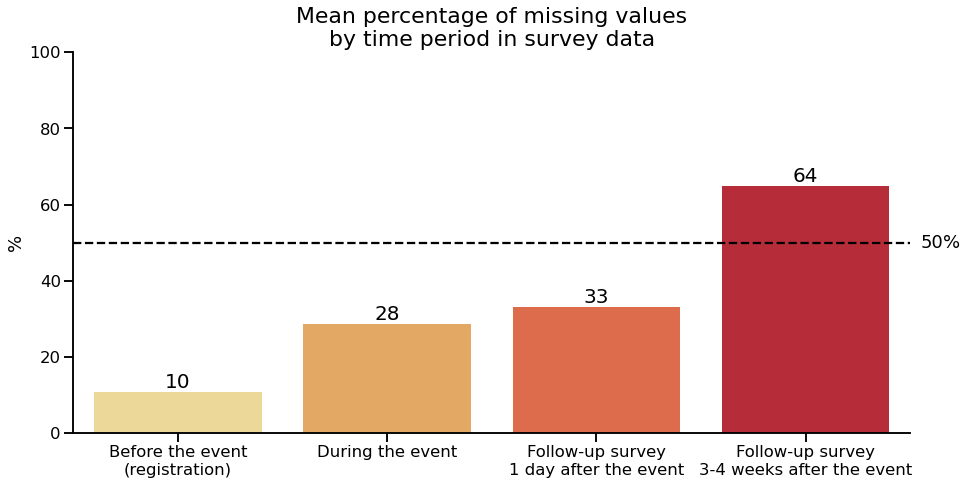

In [27]:
sns.set_context("talk") # Setting a default scale for the axis and labels
plt.figure(figsize = (15,7))
plt.title("Mean percentage of missing values\nby time period in survey data", fontdict = {'fontsize': 22})
ax = sns.barplot(x = missing_values_summary.index, y = missing_values_summary.values, saturation = 0.7, palette ="YlOrRd")
ax.bar_label(ax.containers[0], fmt = '%d', fontsize = 20) # Adding values over bars, shown as integers
plt.axhline(y = 50, ls = '--', c = 'Black')
ax.text(3.55, 50,'50%', verticalalignment = 'center', fontsize=18)
ax.set_ylim([0, 100])
ax.set_ylabel('%')

sns.despine() # removing the right and top frame lines around the figure
plt.show()

-> We can confirm that **the percentage of missing values increase over time of the experiment.** 

Reading the data features description of the experiment, we see that (in each case, we do not know if some data was specified as mandatory or not): 
1. Before the event : survey filled out by the students interested in participating
2. During the event : a part of the survey is filled at the beggining and the other part halfway-through
3. Follow-up survey (1 day) : information to be filled out by the students in order to be send their matches (incentive to answer)
4. Follow-up survey (3-4 weeks) : 3-4 weeks after the students have been sent their matches - no incentives to answer are specified

We could interpret that increase of NA values over time by a progressive disinterest in the questions asked in the surveys, or maybe by an increasing complexity of the questions.

Now let's check if we can identify some other factors that tend to increase the missing values, and if it says something about the participants.

In [28]:
missing_values_figs = make_subplots(rows = len(missing_values_series_list), cols = 1, subplot_titles = time_labels, vertical_spacing = 0.1) # 1 subplot by time period

for i, (missing_values_part_series, time_label) in enumerate(zip(missing_values_series_list, time_labels)):
    missing_values_figs.add_trace(go.Bar(x = missing_values_part_series.index, y = missing_values_part_series.values, name = time_label),
                                  row = i+1,
                                  col = 1)
    missing_values_figs.add_hline(y = missing_values_summary.loc[time_label], 
                                  line_color = 'black', 
                                  line_dash = 'dash', 
                                  annotation_text = f'mean<br>({round(missing_values_summary.loc[time_label])}%)', # plotly annotations are in html format
                                  annotation_xanchor = 'left', 
                                  annotation_x = 1.01, 
                                  annotation_font_size = 14, #the last arguments are kwargs from the add_shape arguments and layout.Annotation properties
                                  row = i+1,
                                  col = 1
                                 )   

missing_values_figs.update_yaxes(range = [0,100], title = '%')
missing_values_figs.update_xaxes(tickangle = -90, tickfont_size = 12)
missing_values_figs.update_layout(
    title = go.layout.Title(text = "Percentage of missing values in the survey data", x = 0.5, font_size = 22),
    showlegend = False,
    legend_title = 'Time of the study',
    legend_xanchor = 'left',
    legend_x = 1.05,
    legend_y = 0.5,
    legend_font_size = 16,
    height = 1300,
    width = 1500,
    autosize = False,
    
)
missing_values_figs.show()

We first notice that for the data gathered during the event, every participant has filled the 'dec' data, corresponding to whether they would want to see again each partner.  
Also for the registration survey, the most filled data have a missing values ratio < 1%, which we will consider as zero.  

**But for the surveys after the event, every question has at least 10% missing values for the "1-day-after survey" and 52% for the "3-4-weeks-after survey".**   

#### 2.3.2. A not so long-lasting commitment (to the survey)

Lets see how many participants have not filled any part of each survey. 

In [29]:
df_by_iid_reg = df_by_iid.loc[:,'age':'amb5_1']
df_by_iid_event = df_by_iid.loc[:,'dec':'amb3_s']
df_by_iid_after_1d = df_by_iid.loc[:,'satis_2':'amb5_2']
df_by_iid_after_3w = df_by_iid.loc[:,'you_call':]
df_by_iid_list = [df_by_iid_reg, df_by_iid_event, df_by_iid_after_1d, df_by_iid_after_3w]

In [30]:
after_1d_no_answer = df_by_iid_after_1d.isnull().all(axis = 1)
after_1d_no_answer_ratio = after_1d_no_answer.value_counts()[True]/len(after_1d_no_answer)*100
after_3w_no_answer = df_by_iid_after_3w.isnull().all(axis = 1)
after_3w_no_answer_ratio = after_3w_no_answer.value_counts()[True]/len(after_3w_no_answer)*100
no_answer_ratio = [after_1d_no_answer_ratio, after_3w_no_answer_ratio]

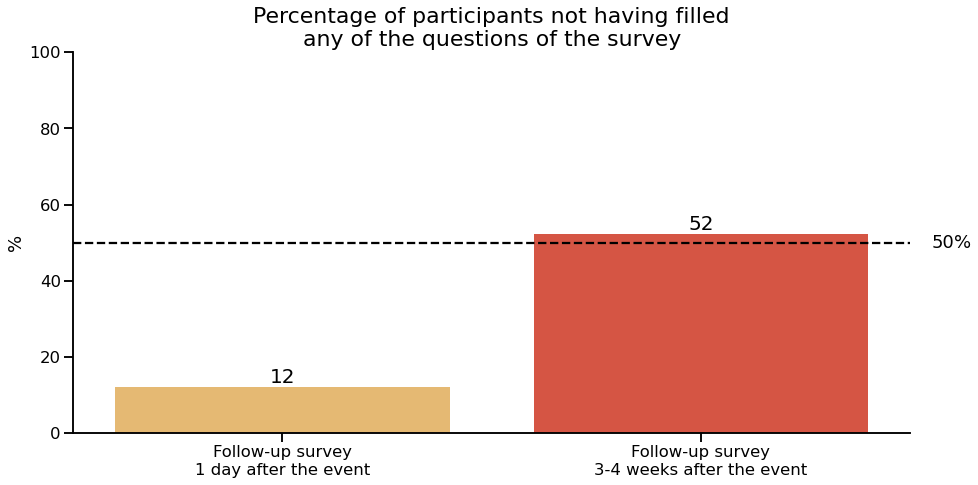

In [31]:
sns.set_context("talk") # Setting a default scale for the axis and labels
plt.figure(figsize = (15,7))
plt.title("Percentage of participants not having filled\nany of the questions of the survey", fontdict = {'fontsize': 22})
ax = sns.barplot(x = time_labels[2:], y = no_answer_ratio, saturation = 0.7, palette ="YlOrRd")
ax.bar_label(ax.containers[0], fmt = '%.0f', fontsize = 20) # Adding values over bars, shown as integers
plt.axhline(y = 50, ls = '--', c = 'Black')
ax.text(1.55, 50,'50%', verticalalignment = 'center', fontsize=18)
ax.set_ylim([0, 100])
ax.set_ylabel('%')

sns.despine() # removing the right and top frame lines around the figure
plt.show()

-> We see that **for the final part of the survey, a majority of students did not respond at all !**    

To see if some questions in particular were harder to respond than others, we have to compare them without taking in account in the missing values calculation the people not having responded at all. 

In [32]:
def get_missing_values_percentage_rescaled(dataframe):
    # Input : dataframe (n rows, m columns)
    # Output : a series (m values) whose indexes are the input dataframe column names 
    #          and the values are the percentage of missing values found in the column,
    #          rounded to 2 decimal places, 
    #          after removal in the input dataframe of the lines having only missing values
    clean_dataframe = dataframe[~dataframe.isnull().all(axis = 1)] # Taking away the lines with only NAN values
    print(f"Found {100-round(clean_dataframe.shape[0]/dataframe.shape[0]*100)}% of lines having only NA values, removed from the calculation of missing values percentage.")
    return clean_dataframe.isnull().sum().apply(lambda x : round(x/clean_dataframe.shape[0]*100, 2)) 

In [33]:
after_1d_missing_values_series_rescaled = get_missing_values_percentage_rescaled(df_after_1d)
after_3w_missing_values_series_rescaled = get_missing_values_percentage_rescaled(df_after_3w)

Found 11% of lines having only NA values, removed from the calculation of missing values percentage.
Found 53% of lines having only NA values, removed from the calculation of missing values percentage.


In [34]:
missing_values_series_rescaled_list = missing_values_series_list[:2] + [after_1d_missing_values_series_rescaled, after_3w_missing_values_series_rescaled]

In [35]:
missing_values_rescaled_summary = []
for i, df_part in enumerate(df_list):
    missing_values_mean_percentage = missing_values_series_rescaled_list[i].mean()
    missing_values_rescaled_summary.append(missing_values_mean_percentage)
missing_values_rescaled_summary = pd.Series(missing_values_rescaled_summary, index = time_labels)

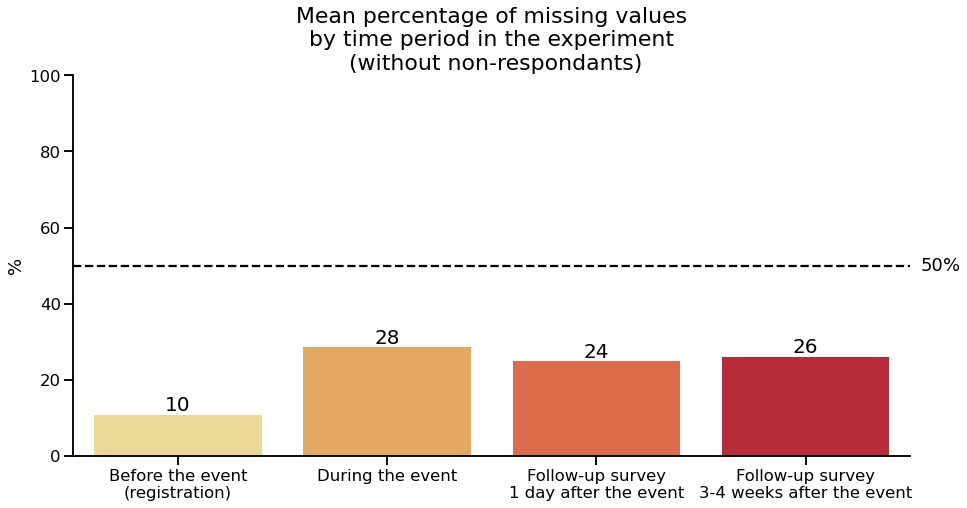

In [36]:
sns.set_context("talk") # Setting a default scale for the axis and labels
plt.figure(figsize = (15,7))
plt.title("Mean percentage of missing values\nby time period in the experiment\n (without non-respondants)", fontdict = {'fontsize': 22})
ax = sns.barplot(x = missing_values_rescaled_summary.index, y = missing_values_rescaled_summary.values, saturation = 0.7, palette ="YlOrRd")
ax.bar_label(ax.containers[0], fmt = '%d', fontsize = 20) # Adding values over bars, shown as integers
plt.axhline(y = 50, ls = '--', c = 'Black')
ax.text(3.55, 50,'50%', verticalalignment = 'center', fontsize=18)
ax.set_ylim([0, 100])
ax.set_ylabel('%')

sns.despine() # removing the right and top frame lines around the figure
plt.show()

-> We see now that, once we took away of each survey data the people not having responded at all, **the missing values rate is much more stable over time, which means that the respondants probably did not struggle more in answering the last survey than the others.** 

**It will hence be easier to compare the missing values rates for specific questions 'on the same scale' across all the survey data.**

In [37]:
missing_values_df_rescaled_list = []
for missing_values_part_series, time_label in zip(missing_values_series_rescaled_list, time_labels):
    missing_values_part_df = pd.DataFrame(missing_values_part_series.values, index = missing_values_part_series.index, columns = ['%_NAN'])
    missing_values_part_df['time_label'] = time_label
    missing_values_df_rescaled_list.append(missing_values_part_df)
missing_values_df_rescaled = pd.concat(missing_values_df_rescaled_list)

In [38]:
rescaled_missing_values_fig = go.Figure(
    data = go.Bar(
        x = [missing_values_df_rescaled['time_label'], missing_values_df_rescaled.index], 
        y = missing_values_df_rescaled['%_NAN']),
    layout = go.Layout(
        title = go.layout.Title(text = "Missing values percentage in the survey data <br>(without non-respondants)", x = 0.5),
        xaxis = go.layout.XAxis(title = 'data',  tickangle = -90, rangeslider = go.layout.xaxis.Rangeslider(visible = True)),
        yaxis = go.layout.YAxis(title = '%', range = [0, 100])
    )
)

rescaled_missing_values_fig.add_hline(y = missing_values_df_rescaled['%_NAN'].mean(), line_color = 'black', 
                              line_dash = 'dash', 
                              annotation_text = f"mean<br>({round(missing_values_df_rescaled['%_NAN'].mean())}%)", # plotly annotations are in html format
                              annotation_xanchor = 'left', 
                              annotation_x = 1.01, 
                              annotation_font_size = 14) #the last arguments are kwargs from the add_shape arguments and layout.Annotation properties 

rescaled_missing_values_fig.show()

**-> if we take away the temporal aspect of quantity of missing values, we see that some questions are much more oftenly skipped than others :**  

**Before the event :** 
- the information missing the most (78% !) is 'expnum', the expected number of matches the student will likely have during the event. As we notice also that there are more than 41% missing values for all attributes relative to how the student is perceived by others (attributes '5_1'), it seems the participants are not really keen on evaluating themselves amongst others on the 'market of love'...
    It doesn't mean although that they don't want to talk about themselves, because we see that the questions on how do the student measure up have a nearly maximum response rate !  
- the questions on the background of the particpants ('undergra', 'mn_sat', 'tuition' and 'income') are also very oftenly skipped (between 40% and 60%)

**During the event :**
- a majority of people don't have answered to the last questions concerning what they look for in the opposite sex (attributes '1_s') and how they measure up themselves (attributes '3_s'). It turns out that all these questions come halfway through the meeting. It is difficult at this point to interpret if the lack of answers was due to organization or to the relevance of the questions perceived by the students.

**1 day after the event :**  
- Many of the respondants (73%) have not answered the questions regarding the role played by the differents attributes of partners in the yes/no decisions during the event.
- We see that this time, students were more interested in answering about themselves (what they look for -attributes '1_2', and how they measure up -attributes '3_2') than in assuming about others (attributes '4_2', '2_2' and '5_2'). One thing that doesn't change since before the event is they still don't know or don't want to tell how they think others perceive them.

**3-4 weeks after matches :**
- Many of the respondants (60%) don't have answered to the question regarding how many of their matches they've been on a date with so far, and even more (83% !) didn't answer to the immediate following question 'If yes, how many ?' (maybe because this last question is quite hard to understand !)
- The majority of respondants still don't answer much to the questions regarding the role played by the differents attributes of partners in the yes/no decisions during the event (attributes '7_3') and how others perceive them (attributes '5_3'). 
- This time again, like in the 1-day-after survey, every respondant has answered to the questions regarding themselves (attributes '1_3' and '3_3') and where more hesitant when assuming about others (attributes '4_3' and '2_3'). 

### 2.4. Conclusion

After this analysis on missing values, we can assume that : 

1. There was a clear increase in missing values over time, explained more by a **progressive disinterest of the participants in the study** than by an increasing complexity of the questions (as the missing values rate once we took away the non-respondants is quite constant). The very high rate of non-respondants to the last survey can be explained by **the absence of incentive given to respond** (contrarily to the previous follow-up survey which had to be submitted in order for the participants to be sent their matches), in addition to **the time taken between the event and this last survey.**  

2. Once the temporal aspect set aside, we saw that **the respondants are more eager to answer to questions about their own personality or opinions than on others'.** 

## 3. How to have a second date ?

### 3.1. Attractiveness - Who has the most chances ?

In [39]:
df_by_iid['date_3'].value_counts()/len(df_by_iid)

0.0    0.31
1.0    0.17
Name: date_3, dtype: float64

In [40]:
df['match'].value_counts()/len(df)

0    0.84
1    0.16
Name: match, dtype: float64

In [41]:
df_by_iid['had_match'] = df_by_iid['match'] > 0
df_by_iid['had_date'] = df_by_iid['date_3'].replace({0.0:'No',1.0:'Yes',np.nan:'Unknown'})
df_by_iid['gender']=df_by_iid['gender'].replace({0:'Female',1:'Male'})
df_by_iid

,iid,gender,condtn,wave,round,position,positin1,order,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3,had_match,had_date
iid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,Female,1.0,1.0,10.0,7.0,NaN,5.5,15.5,0.40,2.67e-01,0.10,25.2,2.30,44.23,7.91,16.51,16.91,4.51,9.92,0.50,6.70,7.40,8.00,7.20,8.00,7.10,6.85,5.70,1.90,21.0,Law,1.0,None,None,None,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,0.80,5.70,7.30,7.30,6.80,6.30,6.50,6.50,5.89,1.78,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,True,No
2,2.0,Female,1.0,1.0,10.0,3.0,NaN,5.5,15.5,0.20,2.58e-01,0.80,25.2,2.30,44.23,7.91,16.51,16.91,4.51,9.92,0.60,7.70,7.10,7.90,7.50,7.50,6.50,7.60,5.50,1.90,24.0,law,1.0,None,None,None,2.0,2.0,5.0,Alabama,"35,223","65,929.00",1.0,5.0,1.0,law,NaN,3.0,2.0,7.0,10.0,8.0,6.0,3.0,5.0,8.0,10.0,1.0,9.0,8.0,7.0,8.0,3.0,1.0,4.0,5.0,45.0,5.0,25.0,20.0,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,65.0,0.0,10.0,25.0,0.0,0.0,7.0,5.0,10.0,8.0,3.0,NaN,NaN,NaN,NaN,NaN,0.40,6.40,7.00,7.70,6.10,6.50,5.70,6.60,5.90,1.90,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.92,18.92,21.62,27.03,5.41,8.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,6.0,8.0,9.0,4.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,30.0,5.0,40.0,15.0,0.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,6.0,9.0,9.0,4.0,NaN,NaN,NaN,NaN,NaN,True,No
3,3.0,Female,1.0,1.0,10.0,9.0,NaN,5.5,15.5,0.00,-1.36e-01,0.80,25.2,2.30,44.23,7.91,16.51,16.91,4.51,9.92,0.50,6.50,7.10,7.30,6.20,7.11,6.00,6.00,4.50,1.90,25.0,Economics,2.0,None,None,None,2.0,8.0,4.0,Connecticut,"6,268",None,6.0,3.0,1.0,Economist,NaN,3.0,8.0,7.0,8.0,5.0,5.0,8.0,4.0,5.0,7.0,8.0,7.0,7.0,7.0,5.0,8.0,7.0,4.0,2.0,35.0,10.0,35.0,10.0,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,50.0,0.0,20.0,30.0,0.0,0.0,8.0,9.0,8.0,9.0,8.0,NaN,NaN,NaN,NaN,NaN,0.00,8.10,8.60,9.40,7.70,8.80,8.10,8.20,7.00,1.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [42]:
had_match_df = df_by_iid[df_by_iid["had_match"]==True].drop('match',axis = 1)

In [43]:
dates_vs_matches_figs = make_subplots(rows = 1, cols = 2, subplot_titles = ["With missing values", "Without missing values"], vertical_spacing = 0.1) # 1 subplot by time period


In [44]:
dates_vs_matches_fig = px.histogram(had_match_df, 
                                    x = "gender",
                                    color = "had_date",
                                    color_discrete_map = {'Unknown':"rgba(0, 0, 0, 0.08)"},
                                    category_orders = {'had_date':['No','Yes','Unknown']},
                                    barnorm = 'percent',
                                    barmode = 'group',
                                    width = 700)
#dates_vs_matches_fig.update_layout(showlegend = False)
dates_vs_matches_fig.show()
from pprint import pprint 
#pprint(dates_vs_matches_fig)

In [45]:
corr = df_by_iid.corr().abs().loc[:,['date_3']].drop(['date_3','match','numdat_3','num_in_3','had_match'], axis = 0).transpose()
corr

,iid,condtn,wave,round,position,positin1,order,pid,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field_cd,race,imprace,imprelig,goal,date,go_out,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
date_3,0.1,0.15,0.1,0.13,0.06,3.42e-03,0.13,0.1,0.14,4.04e-03,0.08,0.07,0.03,0.08,8.35e-04,0.01,0.01,9.38e-03,0.28,0.26,0.07,0.11,0.18,0.01,0.16,0.25,0.12,0.01,0.04,0.01,0.04,0.18,0.1,0.03,0.05,0.1,0.04,0.03,0.08,0.02,1.32e-03,0.05,0.04,0.13,0.12,0.05,0.05,0.12,0.05,0.02,0.08,0.04,0.08,0.06,0.08,0.08,0.02,5.48e-03,0.01,0.07,0.01,0.08,0.1,0.13,0.01,0.16,0.07,0.05,0.02,0.08,9.48e-03,0.05,0.15,0.1,0.02,0.05,0.02,0.04,0.03,1.23e-03,0.01,0.03,0.14,0.05,0.06,0.05,0.04,0.03,0.02,7.61e-03,0.02,0.01,0.04,0.15,0.07,0.16,0.06,0.3,0.1,0.06,0.15,0.01,0.03,0.11,0.11,0.06,0.13,0.03,0.08,0.05,0.21,0.1,0.12,0.09,0.04,0.03,0.01,0.04,0.04,0.08,0.05,0.07,0.09,0.04,0.11,0.08,0.02,0.03,0.08,0.09,0.1,0.08,0.12,0.04,0.02,0.09,0.03,0.13,3.72e-03,0.01,0.11,2.79e-03,0.08,0.27,0.49,0.01,0.01,0.03,0.06,0.05,0.08,0.02,0.1,0.02,0.13,0.05,0.05,0.03,0.05,0.06,0.12,0.06,0.02,0.02,0.06,0.13,0.16,0.13,0.17,0.02,0.01,0.05,0.04,0.05,0.07,0.02,0.05,0.03,0.06


In [46]:
print(f"Max correlation : {corr.max().max()}, Min correlation : {corr.min().min()}")

Max correlation : 0.49084331634271594, Min correlation : 0.0008351817707915554


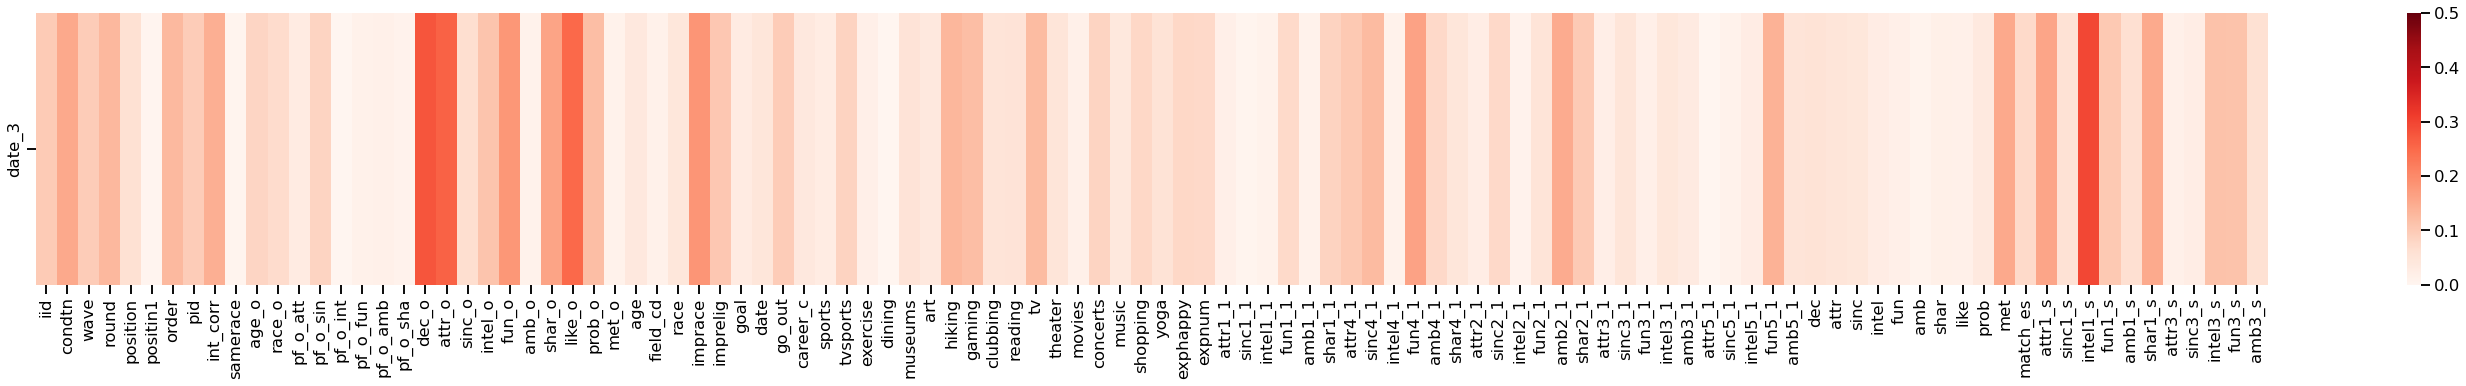

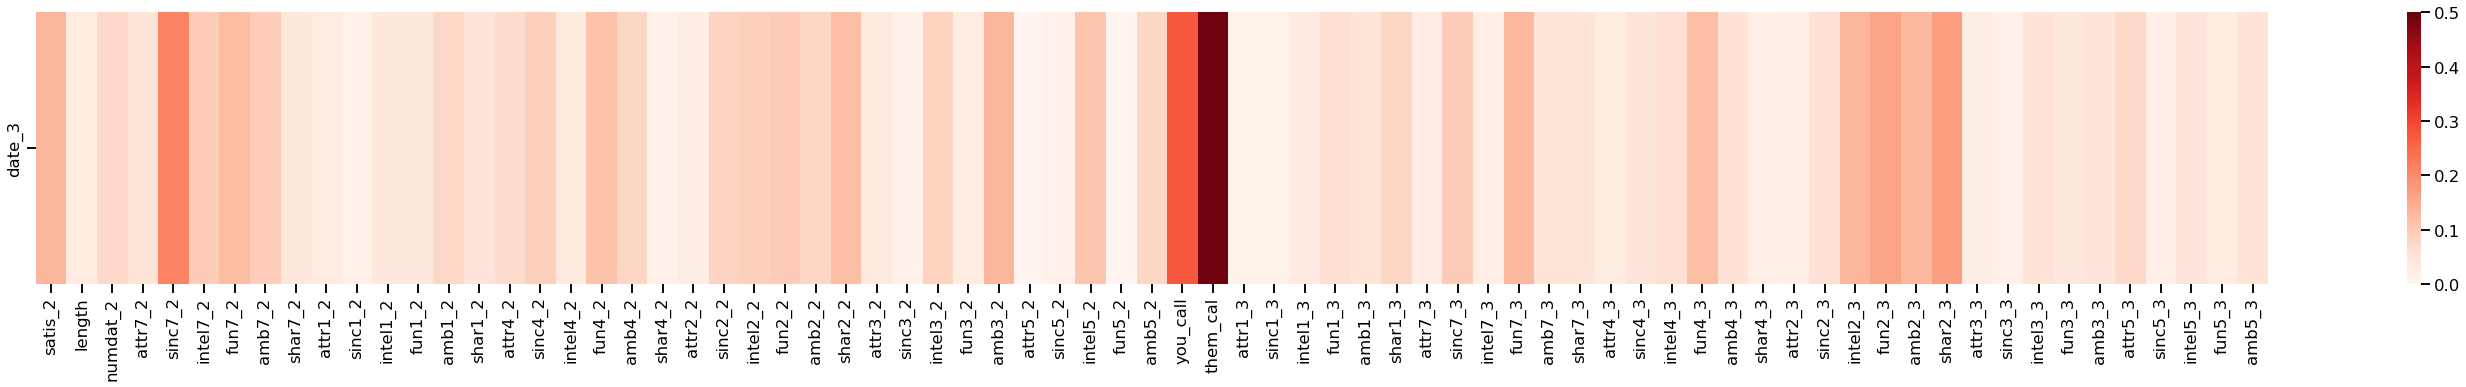

In [47]:
colormap = 'Reds'
plt.figure(figsize = (50,5))
sns.heatmap(corr.loc[:,'iid':'amb3_s'], vmin = 0, vmax = 0.5, cmap = colormap)
plt.show()
plt.figure(figsize = (50,5))
sns.heatmap(corr.loc[:,'satis_2':], vmin = 0, vmax = 0.5, cmap = colormap)
plt.show()

In [48]:
px.bar(corr.transpose())

In [49]:
corr2 = df.corr().abs().loc[:,['date_3']].drop(['date_3','match','numdat_3','num_in_3'], axis = 0)

In [50]:
px.bar(corr2)

### 3.2. Good alchemy - How a man and a woman get along with each other ?

This time, we'll move from focusing on how many chances one have to get a second date to how many chances a speed-dating between one man and one woman has to become a match. 
As in the previous analysis we studied wich caracterizes an attractive person, we'll study know **which caracterizes a good interaction between a man and a woman.** 

#### 3.2.1. Does sharing interests help ?

In [51]:
interests_list = ['sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']

In [52]:
"""
df = df.set_index(['iid','pid'])
df.index
for i in range(50):
    print(df.index.levels[1].unique()[i*50:(i+1)*50])
"""

"\ndf = df.set_index(['iid','pid'])\ndf.index\nfor i in range(50):\n    print(df.index.levels[1].unique()[i*50:(i+1)*50])\n"

In [53]:
# A noter que l'id 118 est sauté

In [54]:
def how_interested_by(person_iid, interest):
    # Input : 
    #    person_iid : iid of the person
    #    interest : interest name in interests_list
    # Output : 
    #    interest grade given by the person with iid <person_iid> in the <interest> activity
    return df_by_iid.loc[person_iid,interest]

In [55]:
#df = pd.concat([df], keys = ["subject's interest"], names = ['evaluation'], axis = 1)

In [56]:
"""
def how_interested_by(person_iid, interest):
    # Input : 
    #    person_iid : iid of the person
    #    interest : interest name in interests_list
    # Output : 
    #    interest grade given by the person with iid <person_iid> in the <interest> activity
    return df_by_iid.loc[person_iid,("subject's interest", interest)]
"""

'\ndef how_interested_by(person_iid, interest):\n    # Input : \n    #    person_iid : iid of the person\n    #    interest : interest name in interests_list\n    # Output : \n    #    interest grade given by the person with iid <person_iid> in the <interest> activity\n    return df_by_iid.loc[person_iid,("subject\'s interest", interest)]\n'

In [57]:
df

,iid,gender,condtn,wave,round,position,positin1,order,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,0,1,1,10,7,NaN,4,11.0,0,0.14,0,27.0,2.0,35.0,20.0,20.0,20.0,0.0,5.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,0,1,1,10,7,NaN,3,12.0,0,0.54,0,22.0,2.0,60.0,0.0,0.0,40.0,0.0,0.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,0,1,1,10,7,NaN,10,13.0,1,0.16,1,22.0,4.0,19.0,18.0,19.0,18.0,14.0,12.0,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,0,1,1,10,7,NaN,5,14.0,1,0.61,0,23.0,2.0,30.0,5.0,15.0,40.0,5.0,5.0,1,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0

In [58]:
"""for interest in interests_list:
    df[("partner's interest", interest)] = df[("subject's interest",'pid')].apply(how_interested_by, args = (interest,)) 
"""

'for interest in interests_list:\n    df[("partner\'s interest", interest)] = df[("subject\'s interest",\'pid\')].apply(how_interested_by, args = (interest,)) \n'

In [59]:
#df.head(12)

In [60]:
df = df.set_index(['iid','pid'])

In [61]:
df

gender  condtn  wave  round  position  positin1  order  match  \
iid pid                                                                    
1   11.0        0       1     1     10         7       NaN      4      0   
    12.0        0       1     1     10         7       NaN      3      0   
    13.0        0       1     1     10         7       NaN     10      1   
    14.0        0       1     1     10         7       NaN      5      1   
    15.0        0       1     1     10         7       NaN      7      1   
...           ...     ...   ...    ...       ...       ...    ...    ...   
552 526.0       1       2    21     22        14      10.0      5      0   
    527.0       1       2    21     22        13      10.0      4      0   
    528.0       1       2    21     22        19      10.0     10      0   
    529.0       1       2    21     22         3      10.0     16      0   
    530.0       1       2    21     22         2      10.0     15      0   

           int_corr  samerace  age_o  race_o  pf_o_att  pf_o_sin  pf_o_int  \
iid pid                                                                      
1   11.0       0.14         0   27.0     2.0      35.0      20.0      20.0   
    12.0       0.54         0   22.0     2.0      60.0       0.0       0.0   
    13.0       0.16         1   22.0     4.0      19.0      18.0      19.0   
    14.0       0.61         0   23.0     2.0      30.0       5.0      15.0   
    15.0       0.21         0   24.0     3.0      30.0      10.0      20.0   
...             ...       ...    ...     ...       ...       ...       ...   
552 526.0      0.64         0   26.0     3.0      10.0      10.0      30.0   
    527.0      0.71         0   24.0     6.0      50.0      20.0      10.0   
    528.0     -0.46         0   29.0     3.0      40.0      10.0      30.0   
    529.0      0.62         0   22.0     4.0      10.0      25.0      25.0   
    530.0      0.01         0   22.0     4.0      20.0      20.0      10.0   

           pf_o_fun  pf_o_amb  pf_o_sha  dec_o  attr_o  sinc_o  intel_o  \
iid pid                                                                   
1   11.0       20.0       0.0       5.0      0     6.0     8.0      8.0   
    12.0       40.0       0.0       0.0      0     7.0     8.0     10.0   
    13.0       18.0      14.0      12.0      1    10.0    10.0     10.0   
    14.0       40.0       5.0       5.0      1     7.0     8.0      9.0   
    15.0       10.0      10.0      20.0      1     8.0     7.0      9.0   
...             ...       ...       ...    ...     ...     ...      ...   
552 526.0      20.0      10.0      15.0      1    10.0     5.0      3.0   
    527.0       5.0      10.0       5.0      0     6.0     3.0      7.0   
    528.0      10.0      10.0       NaN      0     2.0     1.0      2.0   
    529.0      10.0      10.0      20.0      1     5.0     7.0      5.0   
    530.0      15.0       5.0      30.0      1     8.0     8.0      7.0   

           fun_o  amb_o  shar_o  like_o  prob_o  met_o   age           field  \
iid pid                                                                        
1   11.0     8.0    8.0     6.0     7.0     4.0    2.0  21.0             Law   
    12.0     7.0    7.0     5.0     8.0     4.0    2.0  21.0             Law   
    13.0    10.0   10.0    10.0    10.0    10.0    1.0  21.0             Law   
    14.0     8.0    9.0     8.0     7.0     7.0    2.0  21.0             Law   
    15.0     6.0    9.0     7.0     8.0     6.0    2.0  21.0             Law   
...          ...    ...     ...     ...     ...    ...   ...             ...   
552 526.0    2.0    6.0     5.0     6.0     1.0    NaN  25.0  Climate Dyn...   
    527.0    3.0    7.0     2.0     2.0     2.0    2.0  25.0  Climate Dyn...   
    528.0    2.0    2.0     1.0     2.0     1.0    2.0  25.0  Climate Dyn...   
    529.0    5.0    3.0     6.0     6.0     4.0    2.0  25.0  Climate Dyn...   
    530.0    7.0    7.0     7.0     8.0     5.0    2.0  25.0  Climate D

In [62]:
df.index.levels[0]

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            543, 544, 545, 546, 547, 548, 549, 550, 551, 552],
           dtype='int64', name='iid', length=551)

In [63]:
# defining the data structure/schema of df_interests
# upper_index_list = ['subject interest', 'partner interest', 'delta of interest with partner']
# multi_idx = pd.MultiIndex.from_product([upper_index_list, interests_list])
# multi_idx
#df_interests = df.set_index(['iid','pid'])[interests_list].reindex(columns = multi_idx, level = 1) # broadcasting the values of interest level 
eval_index_level = ["subject's interest", "partner's interest", "delta of interest with partner"]
#multi_idx = pd.MultiIndex.from_arrays([df.index.levels[0], df.index.levels[1], eval_index_level*len(df.index.levels[0]*len(df.index.levels[1]))])
df_subject_interests = pd.concat([df[interests_list]], keys = [eval_index_level[0]], names = ['evaluation'])

In [64]:
df_subject_interests

sports  tvsports  exercise  dining  museums   art  \
evaluation      iid pid                                                        
subject's in... 1   11.0      9.0       2.0       8.0     9.0      1.0   1.0   
                    12.0      9.0       2.0       8.0     9.0      1.0   1.0   
                    13.0      9.0       2.0       8.0     9.0      1.0   1.0   
                    14.0      9.0       2.0       8.0     9.0      1.0   1.0   
                    15.0      9.0       2.0       8.0     9.0      1.0   1.0   
...                           ...       ...       ...     ...      ...   ...   
                552 526.0     8.0       2.0       5.0    10.0     10.0  10.0   
                    527.0     8.0       2.0       5.0    10.0     10.0  10.0   
                    528.0     8.0       2.0       5.0    10.0     10.0  10.0   
                    529.0     8.0       2.0       5.0    10.0     10.0  10.0   
                    530.0     8.0       2.0       5.0    10.0     10.0  10.0   

                           hiking  gaming  clubbing  reading   tv  theater  \
evaluation      iid pid                                                      
subject's in... 1   11.0      5.0     1.0       5.0      6.0  9.0      1.0   
                    12.0      5.0     1.0       5.0      6.0  9.0      1.0   
                    13.0      5.0     1.0       5.0      6.0  9.0      1.0   
                    14.0      5.0     1.0       5.0      6.0  9.0      1.0   
                    15.0      5.0     1.0       5.0      6.0  9.0      1.0   
...                           ...     ...       ...      ...  ...      ...   
                552 526.0     7.0     1.0       9.0      8.0  3.0      7.0   
                    527.0     7.0     1.0       9.0      8.0  3.0      7.0   
                    528.0     7.0     1.0       9.0      8.0  3.0      7.0   
                    529.0     7.0     1.0       9.0      8.0  3.0      7.0   
                    530.0     7.0     1.0       9.0      8.0  3.0      7.0   

                           movies  concerts  music  shopping  yoga  
evaluation      iid pid                                             
subject's in... 1   11.0     10.0      10.0    9.0       8.0   1.0  
                    12.0     10.0      10.0    9.0       8.0   1.0  
                    13.0     10.0      10.0    9.0       8.0   1.0  
                    14.0     10.0      10.0    9.0       8.0   1.0  
                    15.0     10.0      10.0    9.0       8.0   1.0  
...                           ...       ...    ...       ...   ...  
                552 526.0     9.0      10.0   10.0       7.0   3.0  
                    527.0     9.0      10.0   10.0       7.0   3.0  
                    528.0     9.0      10.0   10.0       7.0   3.0  
                    529.0     9.0      10.0   10.0       7.0   3.0  
                    530.0     9.0      10.0   10.0       7.0   3.0  

[8368 rows x 17 columns]

In [65]:
df_subject_interests.isna().sum()

sports      79
tvsports    79
exercise    79
dining      79
museums     79
art         79
hiking      79
gaming      79
clubbing    79
reading     79
tv          79
theater     79
movies      79
concerts    79
music       79
shopping    79
yoga        79
dtype: int64

In [66]:
df_subject_interests.isna().all(axis = 1)

evaluation          iid  pid  
subject's interest  1    11.0     False
                         12.0     False
                         13.0     False
                         14.0     False
                         15.0     False
                                  ...  
                    552  526.0    False
                         527.0    False
                         528.0    False
                         529.0    False
                         530.0    False
Length: 8368, dtype: bool

In [67]:
print("Number of rows concerning people not having told any of their interests :", len(df_subject_interests[df_subject_interests.isna().all(axis = 1)]))

Number of rows concerning people not having told any of their interests : 79


In [68]:
print("IIDs of people not having told their interests : ", df_subject_interests[df_subject_interests.isna().all(axis = 1)].index.get_level_values(1).unique().values.tolist())

IIDs of people not having told their interests :  [28, 58, 59, 136, 339, 340, 346]


Only 7 people don't have answered to the survey regarding their interests, we will drop the corresponding rows.

In [69]:
ids_to_drop = df_subject_interests[df_subject_interests.isna().all(axis = 1)].index.get_level_values(1).unique().values.tolist()

In [70]:
df_subject_interests = df_subject_interests.drop(ids_to_drop, axis = 0, level = 1).drop(ids_to_drop, axis = 0, level = 2) # removing both from iid level and pid level, as we will later also need partner's interests information
df_subject_interests

sports  tvsports  exercise  dining  museums   art  \
evaluation      iid pid                                                        
subject's in... 1   11.0      9.0       2.0       8.0     9.0      1.0   1.0   
                    12.0      9.0       2.0       8.0     9.0      1.0   1.0   
                    13.0      9.0       2.0       8.0     9.0      1.0   1.0   
                    14.0      9.0       2.0       8.0     9.0      1.0   1.0   
                    15.0      9.0       2.0       8.0     9.0      1.0   1.0   
...                           ...       ...       ...     ...      ...   ...   
                552 526.0     8.0       2.0       5.0    10.0     10.0  10.0   
                    527.0     8.0       2.0       5.0    10.0     10.0  10.0   
                    528.0     8.0       2.0       5.0    10.0     10.0  10.0   
                    529.0     8.0       2.0       5.0    10.0     10.0  10.0   
                    530.0     8.0       2.0       5.0    10.0     10.0  10.0   

                           hiking  gaming  clubbing  reading   tv  theater  \
evaluation      iid pid                                                      
subject's in... 1   11.0      5.0     1.0       5.0      6.0  9.0      1.0   
                    12.0      5.0     1.0       5.0      6.0  9.0      1.0   
                    13.0      5.0     1.0       5.0      6.0  9.0      1.0   
                    14.0      5.0     1.0       5.0      6.0  9.0      1.0   
                    15.0      5.0     1.0       5.0      6.0  9.0      1.0   
...                           ...     ...       ...      ...  ...      ...   
                552 526.0     7.0     1.0       9.0      8.0  3.0      7.0   
                    527.0     7.0     1.0       9.0      8.0  3.0      7.0   
                    528.0     7.0     1.0       9.0      8.0  3.0      7.0   
                    529.0     7.0     1.0       9.0      8.0  3.0      7.0   
                    530.0     7.0     1.0       9.0      8.0  3.0      7.0   

                           movies  concerts  music  shopping  yoga  
evaluation      iid pid                                             
subject's in... 1   11.0     10.0      10.0    9.0       8.0   1.0  
                    12.0     10.0      10.0    9.0       8.0   1.0  
                    13.0     10.0      10.0    9.0       8.0   1.0  
                    14.0     10.0      10.0    9.0       8.0   1.0  
                    15.0     10.0      10.0    9.0       8.0   1.0  
...                           ...       ...    ...       ...   ...  
                552 526.0     9.0      10.0   10.0       7.0   3.0  
                    527.0     9.0      10.0   10.0       7.0   3.0  
                    528.0     9.0      10.0   10.0       7.0   3.0  
                    529.0     9.0      10.0   10.0       7.0   3.0  
                    530.0     9.0      10.0   10.0       7.0   3.0  

[8210 rows x 17 columns]

In [71]:
df_subject_interests.isna().sum()

sports      0
tvsports    0
exercise    0
dining      0
museums     0
art         0
hiking      0
gaming      0
clubbing    0
reading     0
tv          0
theater     0
movies      0
concerts    0
music       0
shopping    0
yoga        0
dtype: int64

In [72]:
df_subject_interests.loc[("subject's interest", slice(None),slice(None))]

sports  tvsports  exercise  dining  museums   art  hiking  gaming  \
iid pid                                                                        
1   11.0      9.0       2.0       8.0     9.0      1.0   1.0     5.0     1.0   
    12.0      9.0       2.0       8.0     9.0      1.0   1.0     5.0     1.0   
    13.0      9.0       2.0       8.0     9.0      1.0   1.0     5.0     1.0   
    14.0      9.0       2.0       8.0     9.0      1.0   1.0     5.0     1.0   
    15.0      9.0       2.0       8.0     9.0      1.0   1.0     5.0     1.0   
...           ...       ...       ...     ...      ...   ...     ...     ...   
552 526.0     8.0       2.0       5.0    10.0     10.0  10.0     7.0     1.0   
    527.0     8.0       2.0       5.0    10.0     10.0  10.0     7.0     1.0   
    528.0     8.0       2.0       5.0    10.0     10.0  10.0     7.0     1.0   
    529.0     8.0       2.0       5.0    10.0     10.0  10.0     7.0     1.0   
    530.0     8.0       2.0       5.0    10.0     10.0  10.0     7.0     1.0   

           clubbing  reading   tv  theater  movies  concerts  music  shopping  \
iid pid                                                                         
1   11.0        5.0      6.0  9.0      1.0    10.0      10.0    9.0       8.0   
    12.0        5.0      6.0  9.0      1.0    10.0      10.0    9.0       8.0   
    13.0        5.0      6.0  9.0      1.0    10.0      10.0    9.0       8.0   
    14.0        5.0      6.0  9.0      1.0    10.0      10.0    9.0       8.0   
    15.0        5.0      6.0  9.0      1.0    10.0      10.0    9.0       8.0   
...             ...      ...  ...      ...     ...       ...    ...       ...   
552 526.0       9.0      8.0  3.0      7.0     9.0      10.0   10.0       7.0   
    527.0       9.0      8.0  3.0      7.0     9.0      10.0   10.0       7.0   
    528.0       9.0      8.0  3.0      7.0     9.0      10.0   10.0       7.0   
    529.0       9.0      8.0  3.0      7.0     9.0      10.0   10.0       7.0   
    530.0       9.0      8.0  3.0      7.0     9.0      10.0   10.0       7.0   

           yoga  
iid pid          
1   11.0    1.0  
    12.0    1.0  
    13.0    1.0  
    14.0    1.0  
    15.0    1.0  
...         ...  
552 526.0   3.0  
    527.0   3.0  
    528.0   3.0  
    529.0   3.0  
    530.0   3.0  

[8210 rows x 17 columns]

In [73]:
#df_subject_interests.loc[("subject's interest", slice(None),slice(None)), 'index'] = df_subject_interests.index

In [74]:
df_subject_interests

sports  tvsports  exercise  dining  museums   art  \
evaluation      iid pid                                                        
subject's in... 1   11.0      9.0       2.0       8.0     9.0      1.0   1.0   
                    12.0      9.0       2.0       8.0     9.0      1.0   1.0   
                    13.0      9.0       2.0       8.0     9.0      1.0   1.0   
                    14.0      9.0       2.0       8.0     9.0      1.0   1.0   
                    15.0      9.0       2.0       8.0     9.0      1.0   1.0   
...                           ...       ...       ...     ...      ...   ...   
                552 526.0     8.0       2.0       5.0    10.0     10.0  10.0   
                    527.0     8.0       2.0       5.0    10.0     10.0  10.0   
                    528.0     8.0       2.0       5.0    10.0     10.0  10.0   
                    529.0     8.0       2.0       5.0    10.0     10.0  10.0   
                    530.0     8.0       2.0       5.0    10.0     10.0  10.0   

                           hiking  gaming  clubbing  reading   tv  theater  \
evaluation      iid pid                                                      
subject's in... 1   11.0      5.0     1.0       5.0      6.0  9.0      1.0   
                    12.0      5.0     1.0       5.0      6.0  9.0      1.0   
                    13.0      5.0     1.0       5.0      6.0  9.0      1.0   
                    14.0      5.0     1.0       5.0      6.0  9.0      1.0   
                    15.0      5.0     1.0       5.0      6.0  9.0      1.0   
...                           ...     ...       ...      ...  ...      ...   
                552 526.0     7.0     1.0       9.0      8.0  3.0      7.0   
                    527.0     7.0     1.0       9.0      8.0  3.0      7.0   
                    528.0     7.0     1.0       9.0      8.0  3.0      7.0   
                    529.0     7.0     1.0       9.0      8.0  3.0      7.0   
                    530.0     7.0     1.0       9.0      8.0  3.0      7.0   

                           movies  concerts  music  shopping  yoga  
evaluation      iid pid                                             
subject's in... 1   11.0     10.0      10.0    9.0       8.0   1.0  
                    12.0     10.0      10.0    9.0       8.0   1.0  
                    13.0     10.0      10.0    9.0       8.0   1.0  
                    14.0     10.0      10.0    9.0       8.0   1.0  
                    15.0     10.0      10.0    9.0       8.0   1.0  
...                           ...       ...    ...       ...   ...  
                552 526.0     9.0      10.0   10.0       7.0   3.0  
                    527.0     9.0      10.0   10.0       7.0   3.0  
                    528.0     9.0      10.0   10.0       7.0   3.0  
                    529.0     9.0      10.0   10.0       7.0   3.0  
                    530.0     9.0      10.0   10.0       7.0   3.0  

[8210 rows x 17 columns]

In [75]:
df_subject_interests.index

MultiIndex([('subject's interest',   1,  11.0),
            ('subject's interest',   1,  12.0),
            ('subject's interest',   1,  13.0),
            ('subject's interest',   1,  14.0),
            ('subject's interest',   1,  15.0),
            ('subject's interest',   1,  16.0),
            ('subject's interest',   1,  17.0),
            ('subject's interest',   1,  18.0),
            ('subject's interest',   1,  19.0),
            ('subject's interest',   1,  20.0),
            ...
            ('subject's interest', 552, 521.0),
            ('subject's interest', 552, 522.0),
            ('subject's interest', 552, 523.0),
            ('subject's interest', 552, 524.0),
            ('subject's interest', 552, 525.0),
            ('subject's interest', 552, 526.0),
            ('subject's interest', 552, 527.0),
            ('subject's interest', 552, 528.0),
            ('subject's interest', 552, 529.0),
            ('subject's interest', 552, 530.0)],
           names=['eval

In [76]:
df_subject_interests.index.to_flat_index()

Index([   ('subject's interest', 1, 11.0),    ('subject's interest', 1, 12.0),
          ('subject's interest', 1, 13.0),    ('subject's interest', 1, 14.0),
          ('subject's interest', 1, 15.0),    ('subject's interest', 1, 16.0),
          ('subject's interest', 1, 17.0),    ('subject's interest', 1, 18.0),
          ('subject's interest', 1, 19.0),    ('subject's interest', 1, 20.0),
       ...
       ('subject's interest', 552, 521.0), ('subject's interest', 552, 522.0),
       ('subject's interest', 552, 523.0), ('subject's interest', 552, 524.0),
       ('subject's interest', 552, 525.0), ('subject's interest', 552, 526.0),
       ('subject's interest', 552, 527.0), ('subject's interest', 552, 528.0),
       ('subject's interest', 552, 529.0), ('subject's interest', 552, 530.0)],
      dtype='object', length=8210)

In [77]:
df_subject_interests.index[0]

("subject's interest", 1, 11.0)

In [78]:
#df_subject_interests.index.map(lambda x : x[2])

In [79]:
display(df_subject_interests.xs(1, level = 1))
#display(df_subject_interests.loc(axis=0)["subject's interest",11:20,1])
display(df_subject_interests.xs(1, level = 2))

sports  tvsports  exercise  dining  museums  art  \
evaluation      pid                                                      
subject's in... 11.0     9.0       2.0       8.0     9.0      1.0  1.0   
                12.0     9.0       2.0       8.0     9.0      1.0  1.0   
                13.0     9.0       2.0       8.0     9.0      1.0  1.0   
                14.0     9.0       2.0       8.0     9.0      1.0  1.0   
                15.0     9.0       2.0       8.0     9.0      1.0  1.0   
                16.0     9.0       2.0       8.0     9.0      1.0  1.0   
                17.0     9.0       2.0       8.0     9.0      1.0  1.0   
                18.0     9.0       2.0       8.0     9.0      1.0  1.0   
                19.0     9.0       2.0       8.0     9.0      1.0  1.0   
                20.0     9.0       2.0       8.0     9.0      1.0  1.0   

                      hiking  gaming  clubbing  reading   tv  theater  movies  \
evaluation      pid                                                             
subject's in... 11.0     5.0     1.0       5.0      6.0  9.0      1.0    10.0   
                12.0     5.0     1.0       5.0      6.0  9.0      1.0    10.0   
                13.0     5.0     1.0       5.0      6.0  9.0      1.0    10.0   
                14.0     5.0     1.0       5.0      6.0  9.0      1.0    10.0   
                15.0     5.0     1.0       5.0      6.0  9.0      1.0    10.0   
                16.0     5.0     1.0       5.0      6.0  9.0      1.0    10.0   
                17.0     5.0     1.0       5.0      6.0  9.0      1.0    10.0   
                18.0     5.0     1.0       5.0      6.0  9.0      1.0    10.0   
                19.0     5.0     1.0       5.0      6.0  9.0      1.0    10.0   
                20.0     5.0     1.0       5.0      6.0  9.0      1.0    10.0   

                      concerts  music  shopping  yoga  
evaluation      pid                                    
subject's in... 11.0      10.0    9.0       8.0   1.0  
                12.0      10.0    9.0       8.0   1.0  
                13.0      10.0    9.0       8.0   1.0  
                14.0      10.0    9.0       8.0   1.0  
                15.0      10.0    9.0       8.0   1.0  
                16.0      10.0    9.0       8.0   1.0  
                17.0      10.0    9.0       8.0   1.0  
                18.0      10.0    9.0       8.0   1.0  
                19.0      10.0    9.0       8.0   1.0  
                20.0      10.0    9.0       8.0   1.0

sports  tvsports  exercise  dining  museums  art  hiking  \
evaluation      iid                                                             
subject's in... 11      8.0       7.0       2.0     6.0      7.0  5.0     5.0   
                12      9.0       7.0       9.0     8.0      7.0  6.0     3.0   
                13      7.0       8.0       2.0     9.0      5.0  6.0     4.0   
                14     10.0       6.0       8.0     8.0      3.0  3.0    10.0   
                15      9.0       7.0       9.0     7.0      4.0  3.0     6.0   
                16      7.0       2.0       6.0     7.0      7.0  7.0     5.0   
                17      8.0       2.0       9.0     7.0      7.0  5.0     4.0   
                18      5.0       5.0       5.0     9.0      4.0  3.0     4.0   
                19     10.0      10.0      10.0    10.0      5.0  5.0     6.0   
                20     10.0      10.0      10.0    10.0      9.0  9.0     4.0   

                     gaming  clubbing  reading   tv  theater  movies  \
evaluation      iid                                                    
subject's in... 11      5.0       4.0      9.0  2.0      4.0     8.0   
                12      3.0       5.0      6.0  6.0      4.0     7.0   
                13      7.0       7.0      6.0  8.0     10.0     8.0   
                14      8.0       8.0      6.0  7.0      3.0    10.0   
                15      7.0       9.0      8.0  6.0      9.0     9.0   
                16      5.0       5.0      8.0  3.0      7.0     8.0   
                17      2.0       6.0      4.0  2.0      7.0     9.0   
                18      4.0       2.0      6.0  9.0      3.0     9.0   
                19      7.0       9.0      8.0  1.0      1.0     7.0   
                20     10.0      10.0      8.0  3.0      8.0     8.0   

                     concerts  music  shopping  yoga  
evaluation      iid                                   
subject's in... 11        7.0    8.0       5.0   1.0  
                12        7.0    9.0       5.0   5.0  
                13        9.0    9.0       8.0   1.0  
                14        6.0    8.0       6.0   1.0  
                15        6.0    7.0       2.0   1.0  
                16        7.0    8.0       6.0   1.0  
                17        7.0    7.0       2.0   2.0  
                18        3.0    6.0       2.0   1.0  
                19        7.0    7.0       7.0  10.0  
                20        6.0    6.0       5.0  10.0

In [80]:
df_partner_interests = df_subject_interests.rename(index={"subject's interest":"partner's interest"})
df_partner_interests

sports  tvsports  exercise  dining  museums   art  \
evaluation      iid pid                                                        
partner's in... 1   11.0      9.0       2.0       8.0     9.0      1.0   1.0   
                    12.0      9.0       2.0       8.0     9.0      1.0   1.0   
                    13.0      9.0       2.0       8.0     9.0      1.0   1.0   
                    14.0      9.0       2.0       8.0     9.0      1.0   1.0   
                    15.0      9.0       2.0       8.0     9.0      1.0   1.0   
...                           ...       ...       ...     ...      ...   ...   
                552 526.0     8.0       2.0       5.0    10.0     10.0  10.0   
                    527.0     8.0       2.0       5.0    10.0     10.0  10.0   
                    528.0     8.0       2.0       5.0    10.0     10.0  10.0   
                    529.0     8.0       2.0       5.0    10.0     10.0  10.0   
                    530.0     8.0       2.0       5.0    10.0     10.0  10.0   

                           hiking  gaming  clubbing  reading   tv  theater  \
evaluation      iid pid                                                      
partner's in... 1   11.0      5.0     1.0       5.0      6.0  9.0      1.0   
                    12.0      5.0     1.0       5.0      6.0  9.0      1.0   
                    13.0      5.0     1.0       5.0      6.0  9.0      1.0   
                    14.0      5.0     1.0       5.0      6.0  9.0      1.0   
                    15.0      5.0     1.0       5.0      6.0  9.0      1.0   
...                           ...     ...       ...      ...  ...      ...   
                552 526.0     7.0     1.0       9.0      8.0  3.0      7.0   
                    527.0     7.0     1.0       9.0      8.0  3.0      7.0   
                    528.0     7.0     1.0       9.0      8.0  3.0      7.0   
                    529.0     7.0     1.0       9.0      8.0  3.0      7.0   
                    530.0     7.0     1.0       9.0      8.0  3.0      7.0   

                           movies  concerts  music  shopping  yoga  
evaluation      iid pid                                             
partner's in... 1   11.0     10.0      10.0    9.0       8.0   1.0  
                    12.0     10.0      10.0    9.0       8.0   1.0  
                    13.0     10.0      10.0    9.0       8.0   1.0  
                    14.0     10.0      10.0    9.0       8.0   1.0  
                    15.0     10.0      10.0    9.0       8.0   1.0  
...                           ...       ...    ...       ...   ...  
                552 526.0     9.0      10.0   10.0       7.0   3.0  
                    527.0     9.0      10.0   10.0       7.0   3.0  
                    528.0     9.0      10.0   10.0       7.0   3.0  
                    529.0     9.0      10.0   10.0       7.0   3.0  
                    530.0     9.0      10.0   10.0       7.0   3.0  

[8210 rows x 17 columns]

In [81]:
for interest in interests_list:
    df_partner_interests.loc[("partner's interest", slice(None),slice(None)),interest]=df_subject_interests.index.map(lambda x : df_by_iid.loc[x[2],interest])

In [82]:
df_partner_interests

sports  tvsports  exercise  dining  museums  art  \
evaluation      iid pid                                                       
partner's in... 1   11.0      8.0       7.0       2.0     6.0      7.0  5.0   
                    12.0      9.0       7.0       9.0     8.0      7.0  6.0   
                    13.0      7.0       8.0       2.0     9.0      5.0  6.0   
                    14.0     10.0       6.0       8.0     8.0      3.0  3.0   
                    15.0      9.0       7.0       9.0     7.0      4.0  3.0   
...                           ...       ...       ...     ...      ...  ...   
                552 526.0     2.0       1.0       3.0    10.0     10.0  7.0   
                    527.0     5.0       5.0       1.0     8.0      7.0  7.0   
                    528.0     5.0       8.0       4.0     2.0      2.0  2.0   
                    529.0     7.0       4.0       6.0    10.0      8.0  8.0   
                    530.0     7.0      10.0       5.0     6.0      3.0  8.0   

                           hiking  gaming  clubbing  reading   tv  theater  \
evaluation      iid pid                                                      
partner's in... 1   11.0      5.0     5.0       4.0      9.0  2.0      4.0   
                    12.0      3.0     3.0       5.0      6.0  6.0      4.0   
                    13.0      4.0     7.0       7.0      6.0  8.0     10.0   
                    14.0     10.0     8.0       8.0      6.0  7.0      3.0   
                    15.0      6.0     7.0       9.0      8.0  6.0      9.0   
...                           ...     ...       ...      ...  ...      ...   
                552 526.0     6.0     5.0      10.0      8.0  4.0     10.0   
                    527.0     6.0     2.0       7.0      6.0  6.0      8.0   
                    528.0     8.0     6.0       2.0      2.0  2.0      3.0   
                    529.0     8.0     6.0       5.0      5.0  5.0      8.0   
                    530.0     6.0     7.0       6.0      3.0  5.0      8.0   

                           movies  concerts  music  shopping  yoga  
evaluation      iid pid                                             
partner's in... 1   11.0      8.0       7.0    8.0       5.0   1.0  
                    12.0      7.0       7.0    9.0       5.0   5.0  
                    13.0      8.0       9.0    9.0       8.0   1.0  
                    14.0     10.0       6.0    8.0       6.0   1.0  
                    15.0      9.0       6.0    7.0       2.0   1.0  
...                           ...       ...    ...       ...   ...  
                552 526.0     8.0       6.0    8.0       4.0  10.0  
                    527.0     7.0       8.0    8.0       7.0   6.0  
                    528.0     7.0       3.0    3.0       2.0   2.0  
                    529.0     8.0       8.0    8.0       4.0   4.0  
                    530.0    10.0       9.0   10.0       6.0   3.0  

[8210 rows x 17 columns]

In [83]:
df_diff_interests = df_subject_interests.droplevel('evaluation').sub(df_partner_interests.droplevel('evaluation')).abs()
df_diff_interests = pd.concat([df_diff_interests], keys = [eval_index_level[2]], names = ['evaluation'])
df_diff_interests

sports  tvsports  exercise  dining  museums  art  \
evaluation      iid pid                                                       
delta of int... 1   11.0      1.0       5.0       6.0     3.0      6.0  4.0   
                    12.0      0.0       5.0       1.0     1.0      6.0  5.0   
                    13.0      2.0       6.0       6.0     0.0      4.0  5.0   
                    14.0      1.0       4.0       0.0     1.0      2.0  2.0   
                    15.0      0.0       5.0       1.0     2.0      3.0  2.0   
...                           ...       ...       ...     ...      ...  ...   
                552 526.0     6.0       1.0       2.0     0.0      0.0  3.0   
                    527.0     3.0       3.0       4.0     2.0      3.0  3.0   
                    528.0     3.0       6.0       1.0     8.0      8.0  8.0   
                    529.0     1.0       2.0       1.0     0.0      2.0  2.0   
                    530.0     1.0       8.0       0.0     4.0      7.0  2.0   

                           hiking  gaming  clubbing  reading   tv  theater  \
evaluation      iid pid                                                      
delta of int... 1   11.0      0.0     4.0       1.0      3.0  7.0      3.0   
                    12.0      2.0     2.0       0.0      0.0  3.0      3.0   
                    13.0      1.0     6.0       2.0      0.0  1.0      9.0   
                    14.0      5.0     7.0       3.0      0.0  2.0      2.0   
                    15.0      1.0     6.0       4.0      2.0  3.0      8.0   
...                           ...     ...       ...      ...  ...      ...   
                552 526.0     1.0     4.0       1.0      0.0  1.0      3.0   
                    527.0     1.0     1.0       2.0      2.0  3.0      1.0   
                    528.0     1.0     5.0       7.0      6.0  1.0      4.0   
                    529.0     1.0     5.0       4.0      3.0  2.0      1.0   
                    530.0     1.0     6.0       3.0      5.0  2.0      1.0   

                           movies  concerts  music  shopping  yoga  
evaluation      iid pid                                             
delta of int... 1   11.0      2.0       3.0    1.0       3.0   0.0  
                    12.0      3.0       3.0    0.0       3.0   4.0  
                    13.0      2.0       1.0    0.0       0.0   0.0  
                    14.0      0.0       4.0    1.0       2.0   0.0  
                    15.0      1.0       4.0    2.0       6.0   0.0  
...                           ...       ...    ...       ...   ...  
                552 526.0     1.0       4.0    2.0       3.0   7.0  
                    527.0     2.0       2.0    2.0       0.0   3.0  
                    528.0     2.0       7.0    7.0       5.0   1.0  
                    529.0     1.0       2.0    2.0       3.0   1.0  
                    530.0     1.0       1.0    0.0       1.0   0.0  

[8210 rows x 17 columns]

In [84]:
df_interests = pd.concat([df_subject_interests, df_partner_interests, df_diff_interests], axis = 0).reorder_levels([1,2,0], axis = 0).sort_index(level = [0,1], sort_remaining = False)
df_interests

sports  tvsports  exercise  dining  museums   art  \
iid pid   evaluation                                                           
1   11.0  subject's in...     9.0       2.0       8.0     9.0      1.0   1.0   
          partner's in...     8.0       7.0       2.0     6.0      7.0   5.0   
          delta of int...     1.0       5.0       6.0     3.0      6.0   4.0   
    12.0  subject's in...     9.0       2.0       8.0     9.0      1.0   1.0   
          partner's in...     9.0       7.0       9.0     8.0      7.0   6.0   
...                           ...       ...       ...     ...      ...   ...   
552 529.0 partner's in...     7.0       4.0       6.0    10.0      8.0   8.0   
          delta of int...     1.0       2.0       1.0     0.0      2.0   2.0   
    530.0 subject's in...     8.0       2.0       5.0    10.0     10.0  10.0   
          partner's in...     7.0      10.0       5.0     6.0      3.0   8.0   
          delta of int...     1.0       8.0       0.0     4.0      7.0   2.0   

                           hiking  gaming  clubbing  reading   tv  theater  \
iid pid   evaluation                                                         
1   11.0  subject's in...     5.0     1.0       5.0      6.0  9.0      1.0   
          partner's in...     5.0     5.0       4.0      9.0  2.0      4.0   
          delta of int...     0.0     4.0       1.0      3.0  7.0      3.0   
    12.0  subject's in...     5.0     1.0       5.0      6.0  9.0      1.0   
          partner's in...     3.0     3.0       5.0      6.0  6.0      4.0   
...                           ...     ...       ...      ...  ...      ...   
552 529.0 partner's in...     8.0     6.0       5.0      5.0  5.0      8.0   
          delta of int...     1.0     5.0       4.0      3.0  2.0      1.0   
    530.0 subject's in...     7.0     1.0       9.0      8.0  3.0      7.0   
          partner's in...     6.0     7.0       6.0      3.0  5.0      8.0   
          delta of int...     1.0     6.0       3.0      5.0  2.0      1.0   

                           movies  concerts  music  shopping  yoga  
iid pid   evaluation                                                
1   11.0  subject's in...    10.0      10.0    9.0       8.0   1.0  
          partner's in...     8.0       7.0    8.0       5.0   1.0  
          delta of int...     2.0       3.0    1.0       3.0   0.0  
    12.0  subject's in...    10.0      10.0    9.0       8.0   1.0  
          partner's in...     7.0       7.0    9.0       5.0   5.0  
...                           ...       ...    ...       ...   ...  
552 529.0 partner's in...     8.0       8.0    8.0       4.0   4.0  
          delta of int...     1.0       2.0    2.0       3.0   1.0  
    530.0 subject's in...     9.0      10.0   10.0       7.0   3.0  
          partner's in...    10.0       9.0   10.0       6.0   3.0  
          delta of int...     1.0       1.0    0.0       1.0   0.0  

[24630 rows x 17 columns]

In [85]:
df_diff_interests = df_diff_interests.droplevel(0)
df_diff_interests

sports  tvsports  exercise  dining  museums  art  hiking  gaming  \
iid pid                                                                       
1   11.0      1.0       5.0       6.0     3.0      6.0  4.0     0.0     4.0   
    12.0      0.0       5.0       1.0     1.0      6.0  5.0     2.0     2.0   
    13.0      2.0       6.0       6.0     0.0      4.0  5.0     1.0     6.0   
    14.0      1.0       4.0       0.0     1.0      2.0  2.0     5.0     7.0   
    15.0      0.0       5.0       1.0     2.0      3.0  2.0     1.0     6.0   
...           ...       ...       ...     ...      ...  ...     ...     ...   
552 526.0     6.0       1.0       2.0     0.0      0.0  3.0     1.0     4.0   
    527.0     3.0       3.0       4.0     2.0      3.0  3.0     1.0     1.0   
    528.0     3.0       6.0       1.0     8.0      8.0  8.0     1.0     5.0   
    529.0     1.0       2.0       1.0     0.0      2.0  2.0     1.0     5.0   
    530.0     1.0       8.0       0.0     4.0      7.0  2.0     1.0     6.0   

           clubbing  reading   tv  theater  movies  concerts  music  shopping  \
iid pid                                                                         
1   11.0        1.0      3.0  7.0      3.0     2.0       3.0    1.0       3.0   
    12.0        0.0      0.0  3.0      3.0     3.0       3.0    0.0       3.0   
    13.0        2.0      0.0  1.0      9.0     2.0       1.0    0.0       0.0   
    14.0        3.0      0.0  2.0      2.0     0.0       4.0    1.0       2.0   
    15.0        4.0      2.0  3.0      8.0     1.0       4.0    2.0       6.0   
...             ...      ...  ...      ...     ...       ...    ...       ...   
552 526.0       1.0      0.0  1.0      3.0     1.0       4.0    2.0       3.0   
    527.0       2.0      2.0  3.0      1.0     2.0       2.0    2.0       0.0   
    528.0       7.0      6.0  1.0      4.0     2.0       7.0    7.0       5.0   
    529.0       4.0      3.0  2.0      1.0     1.0       2.0    2.0       3.0   
    530.0       3.0      5.0  2.0      1.0     1.0       1.0    0.0       1.0   

           yoga  
iid pid          
1   11.0    0.0  
    12.0    4.0  
    13.0    0.0  
    14.0    0.0  
    15.0    0.0  
...         ...  
552 526.0   7.0  
    527.0   3.0  
    528.0   1.0  
    529.0   1.0  
    530.0   0.0  

[8210 rows x 17 columns]

In [86]:
df

gender  condtn  wave  round  position  positin1  order  match  \
iid pid                                                                    
1   11.0        0       1     1     10         7       NaN      4      0   
    12.0        0       1     1     10         7       NaN      3      0   
    13.0        0       1     1     10         7       NaN     10      1   
    14.0        0       1     1     10         7       NaN      5      1   
    15.0        0       1     1     10         7       NaN      7      1   
...           ...     ...   ...    ...       ...       ...    ...    ...   
552 526.0       1       2    21     22        14      10.0      5      0   
    527.0       1       2    21     22        13      10.0      4      0   
    528.0       1       2    21     22        19      10.0     10      0   
    529.0       1       2    21     22         3      10.0     16      0   
    530.0       1       2    21     22         2      10.0     15      0   

           int_corr  samerace  age_o  race_o  pf_o_att  pf_o_sin  pf_o_int  \
iid pid                                                                      
1   11.0       0.14         0   27.0     2.0      35.0      20.0      20.0   
    12.0       0.54         0   22.0     2.0      60.0       0.0       0.0   
    13.0       0.16         1   22.0     4.0      19.0      18.0      19.0   
    14.0       0.61         0   23.0     2.0      30.0       5.0      15.0   
    15.0       0.21         0   24.0     3.0      30.0      10.0      20.0   
...             ...       ...    ...     ...       ...       ...       ...   
552 526.0      0.64         0   26.0     3.0      10.0      10.0      30.0   
    527.0      0.71         0   24.0     6.0      50.0      20.0      10.0   
    528.0     -0.46         0   29.0     3.0      40.0      10.0      30.0   
    529.0      0.62         0   22.0     4.0      10.0      25.0      25.0   
    530.0      0.01         0   22.0     4.0      20.0      20.0      10.0   

           pf_o_fun  pf_o_amb  pf_o_sha  dec_o  attr_o  sinc_o  intel_o  \
iid pid                                                                   
1   11.0       20.0       0.0       5.0      0     6.0     8.0      8.0   
    12.0       40.0       0.0       0.0      0     7.0     8.0     10.0   
    13.0       18.0      14.0      12.0      1    10.0    10.0     10.0   
    14.0       40.0       5.0       5.0      1     7.0     8.0      9.0   
    15.0       10.0      10.0      20.0      1     8.0     7.0      9.0   
...             ...       ...       ...    ...     ...     ...      ...   
552 526.0      20.0      10.0      15.0      1    10.0     5.0      3.0   
    527.0       5.0      10.0       5.0      0     6.0     3.0      7.0   
    528.0      10.0      10.0       NaN      0     2.0     1.0      2.0   
    529.0      10.0      10.0      20.0      1     5.0     7.0      5.0   
    530.0      15.0       5.0      30.0      1     8.0     8.0      7.0   

           fun_o  amb_o  shar_o  like_o  prob_o  met_o   age           field  \
iid pid                                                                        
1   11.0     8.0    8.0     6.0     7.0     4.0    2.0  21.0             Law   
    12.0     7.0    7.0     5.0     8.0     4.0    2.0  21.0             Law   
    13.0    10.0   10.0    10.0    10.0    10.0    1.0  21.0             Law   
    14.0     8.0    9.0     8.0     7.0     7.0    2.0  21.0             Law   
    15.0     6.0    9.0     7.0     8.0     6.0    2.0  21.0             Law   
...          ...    ...     ...     ...     ...    ...   ...             ...   
552 526.0    2.0    6.0     5.0     6.0     1.0    NaN  25.0  Climate Dyn...   
    527.0    3.0    7.0     2.0     2.0     2.0    2.0  25.0  Climate Dyn...   
    528.0    2.0    2.0     1.0     2.0     1.0    2.0  25.0  Climate Dyn...   
    529.0    5.0    3.0     6.0     6.0     4.0    2.0  25.0  Climate Dyn...   
    530.0    7.0    7.0     7.0     8.0     5.0    2.0  25.0  Climate D

In [87]:
from functools import reduce
series_list = [df_diff_interests[interest] for interest in interests_list]
df_diff_interests['overall']=reduce(lambda series1, series2: series1.add(series2), series_list)

In [88]:
df_diff_interests['match']=df['match']

In [89]:
df_diff_interests

sports  tvsports  exercise  dining  museums  art  hiking  gaming  \
iid pid                                                                       
1   11.0      1.0       5.0       6.0     3.0      6.0  4.0     0.0     4.0   
    12.0      0.0       5.0       1.0     1.0      6.0  5.0     2.0     2.0   
    13.0      2.0       6.0       6.0     0.0      4.0  5.0     1.0     6.0   
    14.0      1.0       4.0       0.0     1.0      2.0  2.0     5.0     7.0   
    15.0      0.0       5.0       1.0     2.0      3.0  2.0     1.0     6.0   
...           ...       ...       ...     ...      ...  ...     ...     ...   
552 526.0     6.0       1.0       2.0     0.0      0.0  3.0     1.0     4.0   
    527.0     3.0       3.0       4.0     2.0      3.0  3.0     1.0     1.0   
    528.0     3.0       6.0       1.0     8.0      8.0  8.0     1.0     5.0   
    529.0     1.0       2.0       1.0     0.0      2.0  2.0     1.0     5.0   
    530.0     1.0       8.0       0.0     4.0      7.0  2.0     1.0     6.0   

           clubbing  reading   tv  theater  movies  concerts  music  shopping  \
iid pid                                                                         
1   11.0        1.0      3.0  7.0      3.0     2.0       3.0    1.0       3.0   
    12.0        0.0      0.0  3.0      3.0     3.0       3.0    0.0       3.0   
    13.0        2.0      0.0  1.0      9.0     2.0       1.0    0.0       0.0   
    14.0        3.0      0.0  2.0      2.0     0.0       4.0    1.0       2.0   
    15.0        4.0      2.0  3.0      8.0     1.0       4.0    2.0       6.0   
...             ...      ...  ...      ...     ...       ...    ...       ...   
552 526.0       1.0      0.0  1.0      3.0     1.0       4.0    2.0       3.0   
    527.0       2.0      2.0  3.0      1.0     2.0       2.0    2.0       0.0   
    528.0       7.0      6.0  1.0      4.0     2.0       7.0    7.0       5.0   
    529.0       4.0      3.0  2.0      1.0     1.0       2.0    2.0       3.0   
    530.0       3.0      5.0  2.0      1.0     1.0       1.0    0.0       1.0   

           yoga  overall  match  
iid pid                          
1   11.0    0.0     52.0      0  
    12.0    4.0     41.0      0  
    13.0    0.0     45.0      1  
    14.0    0.0     36.0      1  
    15.0    0.0     50.0      1  
...         ...      ...    ...  
552 526.0   7.0     39.0      0  
    527.0   3.0     37.0      0  
    528.0   1.0     80.0      0  
    529.0   1.0     33.0      0  
    530.0   0.0     43.0      0  

[8210 rows x 19 columns]

In [90]:
df_diff_interests.reset_index() #plotly express does not accept multiindex

,iid,pid,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,overall,match
0,1,11.0,1.0,5.0,6.0,3.0,6.0,4.0,0.0,4.0,1.0,3.0,7.0,3.0,2.0,3.0,1.0,3.0,0.0,52.0,0
1,1,12.0,0.0,5.0,1.0,1.0,6.0,5.0,2.0,2.0,0.0,0.0,3.0,3.0,3.0,3.0,0.0,3.0,4.0,41.0,0
2,1,13.0,2.0,6.0,6.0,0.0,4.0,5.0,1.0,6.0,2.0,0.0,1.0,9.0,2.0,1.0,0.0,0.0,0.0,45.0,1
3,1,14.0,1.0,4.0,0.0,1.0,2.0,2.0,5.0,7.0,3.0,0.0,2.0,2.0,0.0,4.0,1.0,2.0,0.0,36.0,1
4,1,15.0,0.0,5.0,1.0,2.0,3.0,2.0,1.0,6.0,4.0,2.0,3.0,8.0,1.0,4.0,2.0,6.0,0.0,50.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8205,552,526.0,6.0,1.0,2.0,0.0,0.0,3.0,1.0,4.0,1.0,0.0,1.0,3.0,1.0,4.0,2.0,3.0,7.0,39.0,0
8206,552,527.0,3.0,3.0,4.0,2.0,3.0,3.0,1.0,1.0,2.0,2.0,3.0,1.0,2.0,2.0,2.0,0.0,3.0,37.0,0
8207,552,528.0,3.0,6.0,1.0,8.0,8.0,8.0,1.0,5.0,7.0,6.0,1.0,4.0,2.0,7.0,7.0,5.0,1.0,80.0,0
8208,552,529.0,1.0,2.0,1.0,0.0,2.0,2.0,1.0,5.0,4.0,3.0,2.0,1.0,1.0,2.0,2.0,3.0,1.0,33.0,0


In [91]:
df_diff_interests.reset_index()[['overall', 'match']]

,overall,match
0,52.0,0
1,41.0,0
2,45.0,1
3,36.0,1
4,50.0,1
...,...,...
8205,39.0,0
8206,37.0,0
8207,80.0,0
8208,33.0,0


In [92]:
df_diff_sports = df_diff_interests.reset_index()[['overall', 'match']].groupby('overall').mean()
df_diff_sports

,match
overall,
17.0,0.00
18.0,0.00
19.0,0.00
20.0,0.14
21.0,0.17
...,...
89.0,0.00
95.0,0.00
97.0,1.00


In [93]:
px.histogram(df_diff_sports, x = df_diff_sports.index, y = 'match', range_y = [0,1], histfunc = 'avg', nbins = 40, marginal = 'histogram')

In [94]:
"""
interest = 'sports'
px.histogram(plot_df, x = interest, color = plot_df['match'].astype(str), histnorm='percent', barmode = 'group')
"""

"\ninterest = 'sports'\npx.histogram(plot_df, x = interest, color = plot_df['match'].astype(str), histnorm='percent', barmode = 'group')\n"

In [95]:
"""
for interest in interests_list:
    df_to_plot = df_diff_interests.reset_index()[[interest, 'match']].groupby(interest).mean()
    fig = px.bar(df_to_plot, x = df_to_plot.index, y = 'match', range_y = [0,1])
    fig.show()
"""

"\nfor interest in interests_list:\n    df_to_plot = df_diff_interests.reset_index()[[interest, 'match']].groupby(interest).mean()\n    fig = px.bar(df_to_plot, x = df_to_plot.index, y = 'match', range_y = [0,1])\n    fig.show()\n"

In [96]:
"""for interest in interests_list:
    display(px.bar(df_diff_interests, x = interest, y = 'match'))"""

"for interest in interests_list:\n    display(px.bar(df_diff_interests, x = interest, y = 'match'))"

In [97]:
px.bar(df_diff_interests, x = 'sports', y = 'match')

#### 3.2.2. Influence of favorite interests

In [98]:
df_interests = df_interests.drop(index = 'delta of interest with partner', level = 2)
df_interests

sports  tvsports  exercise  dining  museums   art  \
iid pid   evaluation                                                           
1   11.0  subject's in...     9.0       2.0       8.0     9.0      1.0   1.0   
          partner's in...     8.0       7.0       2.0     6.0      7.0   5.0   
    12.0  subject's in...     9.0       2.0       8.0     9.0      1.0   1.0   
          partner's in...     9.0       7.0       9.0     8.0      7.0   6.0   
    13.0  subject's in...     9.0       2.0       8.0     9.0      1.0   1.0   
...                           ...       ...       ...     ...      ...   ...   
552 528.0 partner's in...     5.0       8.0       4.0     2.0      2.0   2.0   
    529.0 subject's in...     8.0       2.0       5.0    10.0     10.0  10.0   
          partner's in...     7.0       4.0       6.0    10.0      8.0   8.0   
    530.0 subject's in...     8.0       2.0       5.0    10.0     10.0  10.0   
          partner's in...     7.0      10.0       5.0     6.0      3.0   8.0   

                           hiking  gaming  clubbing  reading   tv  theater  \
iid pid   evaluation                                                         
1   11.0  subject's in...     5.0     1.0       5.0      6.0  9.0      1.0   
          partner's in...     5.0     5.0       4.0      9.0  2.0      4.0   
    12.0  subject's in...     5.0     1.0       5.0      6.0  9.0      1.0   
          partner's in...     3.0     3.0       5.0      6.0  6.0      4.0   
    13.0  subject's in...     5.0     1.0       5.0      6.0  9.0      1.0   
...                           ...     ...       ...      ...  ...      ...   
552 528.0 partner's in...     8.0     6.0       2.0      2.0  2.0      3.0   
    529.0 subject's in...     7.0     1.0       9.0      8.0  3.0      7.0   
          partner's in...     8.0     6.0       5.0      5.0  5.0      8.0   
    530.0 subject's in...     7.0     1.0       9.0      8.0  3.0      7.0   
          partner's in...     6.0     7.0       6.0      3.0  5.0      8.0   

                           movies  concerts  music  shopping  yoga  
iid pid   evaluation                                                
1   11.0  subject's in...    10.0      10.0    9.0       8.0   1.0  
          partner's in...     8.0       7.0    8.0       5.0   1.0  
    12.0  subject's in...    10.0      10.0    9.0       8.0   1.0  
          partner's in...     7.0       7.0    9.0       5.0   5.0  
    13.0  subject's in...    10.0      10.0    9.0       8.0   1.0  
...                           ...       ...    ...       ...   ...  
552 528.0 partner's in...     7.0       3.0    3.0       2.0   2.0  
    529.0 subject's in...     9.0      10.0   10.0       7.0   3.0  
          partner's in...     8.0       8.0    8.0       4.0   4.0  
    530.0 subject's in...     9.0      10.0   10.0       7.0   3.0  
          partner's in...    10.0       9.0   10.0       6.0   3.0  

[16420 rows x 17 columns]

In [99]:
df_interests['favorite interest'] = df_interests.idxmax(axis = 1)

In [100]:
df_interests

sports  tvsports  exercise  dining  museums   art  \
iid pid   evaluation                                                           
1   11.0  subject's in...     9.0       2.0       8.0     9.0      1.0   1.0   
          partner's in...     8.0       7.0       2.0     6.0      7.0   5.0   
    12.0  subject's in...     9.0       2.0       8.0     9.0      1.0   1.0   
          partner's in...     9.0       7.0       9.0     8.0      7.0   6.0   
    13.0  subject's in...     9.0       2.0       8.0     9.0      1.0   1.0   
...                           ...       ...       ...     ...      ...   ...   
552 528.0 partner's in...     5.0       8.0       4.0     2.0      2.0   2.0   
    529.0 subject's in...     8.0       2.0       5.0    10.0     10.0  10.0   
          partner's in...     7.0       4.0       6.0    10.0      8.0   8.0   
    530.0 subject's in...     8.0       2.0       5.0    10.0     10.0  10.0   
          partner's in...     7.0      10.0       5.0     6.0      3.0   8.0   

                           hiking  gaming  clubbing  reading   tv  theater  \
iid pid   evaluation                                                         
1   11.0  subject's in...     5.0     1.0       5.0      6.0  9.0      1.0   
          partner's in...     5.0     5.0       4.0      9.0  2.0      4.0   
    12.0  subject's in...     5.0     1.0       5.0      6.0  9.0      1.0   
          partner's in...     3.0     3.0       5.0      6.0  6.0      4.0   
    13.0  subject's in...     5.0     1.0       5.0      6.0  9.0      1.0   
...                           ...     ...       ...      ...  ...      ...   
552 528.0 partner's in...     8.0     6.0       2.0      2.0  2.0      3.0   
    529.0 subject's in...     7.0     1.0       9.0      8.0  3.0      7.0   
          partner's in...     8.0     6.0       5.0      5.0  5.0      8.0   
    530.0 subject's in...     7.0     1.0       9.0      8.0  3.0      7.0   
          partner's in...     6.0     7.0       6.0      3.0  5.0      8.0   

                           movies  concerts  music  shopping  yoga  \
iid pid   evaluation                                                 
1   11.0  subject's in...    10.0      10.0    9.0       8.0   1.0   
          partner's in...     8.0       7.0    8.0       5.0   1.0   
    12.0  subject's in...    10.0      10.0    9.0       8.0   1.0   
          partner's in...     7.0       7.0    9.0       5.0   5.0   
    13.0  subject's in...    10.0      10.0    9.0       8.0   1.0   
...                           ...       ...    ...       ...   ...   
552 528.0 partner's in...     7.0       3.0    3.0       2.0   2.0   
    529.0 subject's in...     9.0      10.0   10.0       7.0   3.0   
          partner's in...     8.0       8.0    8.0       4.0   4.0   
    530.0 subject's in...     9.0      10.0   10.0       7.0   3.0   
          partner's in...    10.0       9.0   10.0       6.0   3.0   

                          favorite interest  
iid pid   evaluation                         
1   11.0  subject's in...          movies    
          partner's in...         reading    
    12.0  subject's in...          movies    
          partner's in...          sports    
    13.0  subject's in...          movies    
...                                   ...    
552 528.0 partner's in...        tvsports    
    529.0 subject's in...          dining    
          partner's in...          dining    
    530.0 subject's in...          dining    
          partner's in...        tvsports    

[16420 rows x 18 columns]

In [101]:
df_favorite_interests = df_interests.unstack('evaluation').xs(key = 'favorite interest', level = 0, axis = 1)
df_favorite_interests

evaluation subject's interest partner's interest
iid pid                                         
1   11.0            movies            reading   
    12.0            movies             sports   
    13.0            movies            theater   
    14.0            movies             sports   
    15.0            movies             sports   
...                    ...                ...   
552 526.0           dining             dining   
    527.0           dining             dining   
    528.0           dining           tvsports   
    529.0           dining             dining   
    530.0           dining           tvsports   

[8210 rows x 2 columns]

In [102]:
df_favorite_interests['match']=df['match']
df_favorite_interests['gender']=df['gender']
df_favorite_interests

evaluation subject's interest partner's interest  match  gender
iid pid                                                        
1   11.0            movies            reading         0       0
    12.0            movies             sports         0       0
    13.0            movies            theater         1       0
    14.0            movies             sports         1       0
    15.0            movies             sports         1       0
...                    ...                ...       ...     ...
552 526.0           dining             dining         0       1
    527.0           dining             dining         0       1
    528.0           dining           tvsports         0       1
    529.0           dining             dining         0       1
    530.0           dining           tvsports         0       1

[8210 rows x 4 columns]

In [103]:
df_favorite_interests['match'].value_counts()/len(df_favorite_interests)

0    0.84
1    0.16
Name: match, dtype: float64

Let's first try to identify if they're some "incompatibilites" of interests that make a pair of people matching less than average :
(we can read the graph vertically as the dataset is 'symetrical' over subjects and partners)

In [104]:
interests_list

['sports',
 'tvsports',
 'exercise',
 'dining',
 'museums',
 'art',
 'hiking',
 'gaming',
 'clubbing',
 'reading',
 'tv',
 'theater',
 'movies',
 'concerts',
 'music',
 'shopping',
 'yoga']

In [105]:
import plotly
plotly.__version__

'5.8.0'

In [106]:
df_favorite_interests[df_favorite_interests['gender']==1]["subject's interest"].value_counts()

sports      1373
dining       614
reading      496
music        270
exercise     207
tvsports     197
movies       180
museums      129
hiking       121
gaming       115
concerts     110
art          110
theater       75
clubbing      55
yoga          39
tv            14
Name: subject's interest, dtype: int64

In [107]:
df_favorite_interests[df_favorite_interests["subject's interest"]=='shopping']

evaluation subject's interest partner's interest  match  gender
iid pid                                                        
32  40.0          shopping              music         0       0
    41.0          shopping             gaming         0       0
    42.0          shopping            reading         0       0
    43.0          shopping           tvsports         0       0
    44.0          shopping             hiking         0       0
...                    ...                ...       ...     ...
435 449.0         shopping            reading         1       0
    450.0         shopping             movies         0       0
    451.0         shopping              music         0       0
    452.0         shopping              music         0       0
    453.0         shopping             movies         0       0

[92 rows x 4 columns]

In [108]:
df_favorite_interests['match'].value_counts()

0    6860
1    1350
Name: match, dtype: int64

In [109]:
df_favorite_interests['gender'].value_counts()

0    4105
1    4105
Name: gender, dtype: int64

In [110]:
df_favorite_interests

evaluation subject's interest partner's interest  match  gender
iid pid                                                        
1   11.0            movies            reading         0       0
    12.0            movies             sports         0       0
    13.0            movies            theater         1       0
    14.0            movies             sports         1       0
    15.0            movies             sports         1       0
...                    ...                ...       ...     ...
552 526.0           dining             dining         0       1
    527.0           dining             dining         0       1
    528.0           dining           tvsports         0       1
    529.0           dining             dining         0       1
    530.0           dining           tvsports         0       1

[8210 rows x 4 columns]

In [111]:
df_favorite_interests.isna().sum()

evaluation
subject's interest    0
partner's interest    0
match                 0
gender                0
dtype: int64

In [112]:
subject_interests_repartition = df_favorite_interests.groupby("subject's interest").count().drop(['match',"partner's interest"], axis =1).rename(columns = {'gender':'interest_count'}).rename_axis(columns = 'interests')
subject_interests_repartition['percent'] = subject_interests_repartition['interest_count']/len(df_favorite_interests)*100
subject_interests_repartition.sort_values('percent', ascending = False)

interests,interest_count,percent
subject's interest,,
sports,1981,24.13
dining,1612,19.63
reading,939,11.44
exercise,692,8.43
movies,438,5.33
museums,417,5.08
music,410,4.99
tvsports,277,3.37
hiking,272,3.31


In [113]:
meet_counts = df_favorite_interests.groupby(["subject's interest", "partner's interest"]).count().drop('match', axis =1).rename(columns = {'gender':'interest_pair_count'}).rename_axis(columns = 'interests').reset_index().set_index("subject's interest")
meet_counts

interests,partner's interest,interest_pair_count
subject's interest,,
art,art,4
art,clubbing,2
art,concerts,6
art,dining,59
art,exercise,20
...,...,...
yoga,shopping,2
yoga,sports,17
yoga,theater,1


In [114]:
meet_counts_merged = pd.merge(meet_counts, subject_interests_repartition.drop('percent', axis = 1), left_index = True, right_index = True, how = 'left')
meet_counts_merged

interests,partner's interest,interest_pair_count,interest_count
subject's interest,,,
art,art,4,243
art,clubbing,2,243
art,concerts,6,243
art,dining,59,243
art,exercise,20,243
...,...,...,...
yoga,shopping,2,73
yoga,sports,17,73
yoga,theater,1,73


In [115]:
interest = 'sports'
display(meet_counts_merged.loc[interest])
print(meet_counts_merged.loc[interest,'interest_pair_count'].sum())

interests,partner's interest,interest_pair_count,interest_count
subject's interest,,,
sports,art,68,1981
sports,clubbing,48,1981
sports,concerts,24,1981
sports,dining,419,1981
sports,exercise,190,1981
sports,gaming,21,1981
sports,hiking,85,1981
sports,movies,135,1981
sports,museums,111,1981


1981


In [116]:
meet_counts_merged['meeting_ratio_%']= meet_counts_merged['interest_pair_count']/meet_counts_merged['interest_count']*100
meet_counts_merged

interests,partner's interest,interest_pair_count,interest_count,meeting_ratio_%
subject's interest,,,,
art,art,4,243,1.65
art,clubbing,2,243,0.82
art,concerts,6,243,2.47
art,dining,59,243,24.28
art,exercise,20,243,8.23
...,...,...,...,...
yoga,shopping,2,73,2.74
yoga,sports,17,73,23.29
yoga,theater,1,73,1.37


In [117]:
px.density_heatmap(meet_counts_merged.reset_index(), x = "subject's interest", y = "partner's interest", z = 'meeting_ratio_%', 
                   category_orders = {"subject's interest" : interests_list,
                                      "partner's interest" : list(reversed(interests_list))}, #reversed(<list>) returns an iterator that needs to be converted to a list
                   range_color = [100/len(interests_list)*0.8, 100/len(interests_list)*1.2], height = 1200, color_continuous_scale = 'mint', text_auto = '.1f')

We see that the people whose favorite interests are yoga, shopping, concerts, tv, clubbing and gaming are very under-represented in the dataset. We drop these categories befor continuing our analysis. 

In [118]:
df_favorite_interests

evaluation subject's interest partner's interest  match  gender
iid pid                                                        
1   11.0            movies            reading         0       0
    12.0            movies             sports         0       0
    13.0            movies            theater         1       0
    14.0            movies             sports         1       0
    15.0            movies             sports         1       0
...                    ...                ...       ...     ...
552 526.0           dining             dining         0       1
    527.0           dining             dining         0       1
    528.0           dining           tvsports         0       1
    529.0           dining             dining         0       1
    530.0           dining           tvsports         0       1

[8210 rows x 4 columns]

In [119]:
interests_to_drop = ['yoga','shopping','concerts','tv','clubbing','gaming']
interests_list = [interest for interest in interests_list if interest not in interests_to_drop]
interests_list

['sports',
 'tvsports',
 'exercise',
 'dining',
 'museums',
 'art',
 'hiking',
 'reading',
 'theater',
 'movies',
 'music']

In [120]:
mask1 = df_favorite_interests["partner's interest"].apply(lambda x : True if x not in interests_to_drop else False) 
mask2 = df_favorite_interests["subject's interest"].apply(lambda x : True if x not in interests_to_drop else False)
display(mask1)
display(mask1.value_counts())
print()
display(mask2)
display(mask2.value_counts())

iid  pid  
1    11.0     True
     12.0     True
     13.0     True
     14.0     True
     15.0     True
              ... 
552  526.0    True
     527.0    True
     528.0    True
     529.0    True
     530.0    True
Name: partner's interest, Length: 8210, dtype: bool

True     7533
False     677
Name: partner's interest, dtype: int64

iid  pid  
1    11.0     True
     12.0     True
     13.0     True
     14.0     True
     15.0     True
              ... 
552  526.0    True
     527.0    True
     528.0    True
     529.0    True
     530.0    True
Name: subject's interest, Length: 8210, dtype: bool

True     7533
False     677
Name: subject's interest, dtype: int64

In [121]:
mask = mask1 & mask2
display(mask)
display(mask.value_counts())

iid  pid  
1    11.0     True
     12.0     True
     13.0     True
     14.0     True
     15.0     True
              ... 
552  526.0    True
     527.0    True
     528.0    True
     529.0    True
     530.0    True
Length: 8210, dtype: bool

True     6906
False    1304
dtype: int64

In [122]:
df_favorite_interests = df_favorite_interests[mask]
df_favorite_interests

evaluation subject's interest partner's interest  match  gender
iid pid                                                        
1   11.0            movies            reading         0       0
    12.0            movies             sports         0       0
    13.0            movies            theater         1       0
    14.0            movies             sports         1       0
    15.0            movies             sports         1       0
...                    ...                ...       ...     ...
552 526.0           dining             dining         0       1
    527.0           dining             dining         0       1
    528.0           dining           tvsports         0       1
    529.0           dining             dining         0       1
    530.0           dining           tvsports         0       1

[6906 rows x 4 columns]

In [123]:
df_favorite_interests['match'].value_counts()/len(df_favorite_interests)

0    0.84
1    0.16
Name: match, dtype: float64

In [124]:
display(px.density_heatmap(df_favorite_interests, x = "subject's interest", y = "partner's interest", z = 'match', histfunc = "avg", 
                           category_orders = {"subject's interest" : interests_list,
                                              "partner's interest" : list(reversed(interests_list))}, #reversed(<list>) returns an iterator that needs to be converted to a list
                           marginal_y = 'histogram',
                           range_color = [0,df_favorite_interests.groupby(["subject's interest", "partner's interest"])['match'].mean().max()], height = 600, width = 1100))

As we see in the 2D histogram above (reminder : the global average of matches is 16%)
- the people who seem to fit the most are the hikers and tv sports fans (40% matches in average compared to the 18% global average !)
- the tv sports fans generally fit also really well with music lovers, but not at all with museums lovers
- people who love to exercise get along really well with museum lovers but never with art enthusiasts (it would be interesting to study what makes a difference between a museum lover and an art enthusiast)...
- people who are fond of dining fit similarly with almost everybody apart from the people most interested in exercise, with which they match around 2 times less
- art lovers and hikers are the only people who don't match among themselves, and they never do !
- contrarily, theaters regulars are the people who match the most among themselves
- art and music lovers also never match
- the sport enthusiasts, who represent more than 1/4 of the population, seem to get along quite similarly with everybody, with a preference for hikers (but don't like music, art, book or tv sports lovers so much)
- readers apparently don't match with many people in general (as the average is often below the global one), apart from other readers, and especially not with music or theater enthusiasts, and never with movies fans !

We can have an even more precise view if we put gender in the equation. Let's visualize the same 2D histogram but with all subjects being male (and hence all partners being female, since the experiment was focused exclusively on heterosexual datings)

In [125]:
display(px.density_heatmap(df_favorite_interests[df_favorite_interests['gender']==1], x = "subject's interest", y = "partner's interest", z = 'match', histfunc = "avg", 
                           category_orders = {"subject's interest" : interests_list,
                                              "partner's interest" : list(reversed(interests_list))}, #reversed(<list>) returns an iterator that needs to be converted to a list
                           marginal_x = 'histogram', marginal_y = 'histogram',
                           range_color = [0,0.5], height = 900, width = 1100))

In addition to what we saw in the previous graph, we can see for example that : (reminder : the global average of matches is 16%)
- male hikers and female tv sports fans love each other (100% matches !!), but the latter nearly never match with other men than hikers
- we saw previously that the tv sports fans generally fit also really well with music lovers, but it's only one-way : male tv sports fans match with female music lovers, but never the other way around.
- women who love dining don't match well with men who love exercising
- exercise lovers who get along really well with museum lovers are mainly women but the incompatibility with art enthusiasts is cross-gender
- female art fans fit very often (50%) with men who love to go to museums, but never the other way around !
- in fact, men who love art match very few women apart from those who love dining, theater or most of all, movies (50% matches)
- women who are music fans get along easily with men who are fond of tv sports, dining, hiking or movies